In [53]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
from itertools import combinations
import seaborn as sns
from pmdarima import ARIMA


# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Suppress the specified warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.tsa.statespace.sarimax")


In [54]:
# Load your data into a DataFrame called 'df'
df = pd.read_csv('../Data.csv')

In [55]:
# df = df[df['State'] == 'ALABAMA']

In [56]:
df = df.drop(['Max_Colonies_Pct_Change', 'Pct_Affected_Colony_Collapse_Disorder'], axis=1)

In [57]:
df = df[~((df['State'] == 'HAWAII') & (df['Quarter'].isin(['2022_Q1', '2022_Q2'])))]
df = df.fillna(0)

In [58]:
# Make sure 'Quarter' is in datetime format
df['Quarter'] = pd.to_datetime(df['Quarter'].str.replace('_', '-'))

# Set 'Quarter' as the index and specify the frequency as quarterly ('Q-DEC')
df.set_index('Quarter', inplace=True)
df.index = df.index.to_period('Q-DEC')

# Group data by 'State'
grouped = df.groupby('State')

n_periods_to_forecast = 4  # You can adjust this as needed

accuracy_metrics = {}

progress_count = 0
total_states = df.State.nunique()

# Auto Arima ---- No Exog

In [39]:
# import pandas as pd
# import numpy as np
# from pmdarima import auto_arima
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import matplotlib.pyplot as plt

# results_df = pd.DataFrame(columns=['State', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MPE', 'PRMSE'])

# # Perform SARIMA modeling
# for state, data in grouped:
#     print('Fitting SARIMA for', state)

#     # Split the data
#     tscv = TimeSeriesSplit(n_splits=2)
#     test_data = data.iloc[-n_periods_to_forecast:]
#     train_data = data.iloc[:-n_periods_to_forecast].dropna()

#     # Use auto_arima to find the best model
#     autoarima_model = auto_arima(
#         train_data['Max_Colonies'],
#         seasonal=True,
#         suppress_warnings=False,
#         stepwise=True,
#         start_p=1,  # starting value of p
#         d=None,  # let the algorithm determine the best value for d
#         start_q=1,  # starting value of q
#         max_p=5,  # maximum value of p
#         max_d=2,  # maximum value of d
#         max_q=5,  # maximum value of q
#         start_P=1,  # starting value of P
#         D=None,  # let the algorithm determine the best value for D
#         start_Q=1,  # starting value of Q
#         max_P=5,  # maximum value of P
#         max_D=2,  # maximum value of D
#         max_Q=5,  # maximum value of Q
#         m=4,  # seasonal period
#         trace=False,  # print debugging information
#         maxiter=1000,
#         error_action='raise',  # ignore errors
#         scoring='mse',  # use mean squared error for model selection
#         random_state=42,  # set a random seed for reproducibility
#         n_fits=10,  # number of models to fit (useful for speeding up the process)
#         trend='ct',  # 'ct' includes a constant and a linear trend
#         enforce_stationarity=False,  # do not enforce stationarity
#         enforce_invertibility=False,  # do not enforce invertibility
#         seasonal_test='ocsb',  # use the OCSB test for seasonal unit roots
#         information_criterion='aic'  # use AIC for model selection
#     )

#     # Forecast on the test data
#     forecasted_values, conf_int = autoarima_model.predict(n_periods=n_periods_to_forecast, return_conf_int=True)
    
#     # Calculate accuracy metrics for the best model
#     actual_values = test_data['Max_Colonies'].values

#     mae = mean_absolute_error(actual_values, forecasted_values)
#     mse = mean_squared_error(actual_values, forecasted_values)
#     rmse = np.sqrt(mse)
#     mape = np.mean(np.abs((actual_values - forecasted_values) / actual_values)) * 100
#     mpe = np.mean((actual_values - forecasted_values) / actual_values) * 100
#     prmse = (rmse / np.mean(actual_values)) * 100

#     # Append the result to the DataFrame
#     result_entry = {
#         'State': state,
#         'MAE': mae,
#         'MSE': mse,
#         'RMSE': rmse,
#         'MAPE': mape,
#         'MPE': mpe,
#         'PRMSE': prmse
#     }
#     results_df = results_df.append(result_entry, ignore_index=True)

#     # Plot the forecasts and actual data for the best model
#     test_data.index = test_data.index.to_timestamp().strftime('%Y-%m-%d')
#     conf_int_df = pd.DataFrame(conf_int, columns=['Lower', 'Upper'], index=test_data.index)

#     plt.figure(figsize=(8, 4))
#     plt.plot(test_data.index, forecasted_values, label='Forecast', color='r', linestyle='dashed')
#     plt.plot(test_data.index, actual_values, label='Actual', color='b')
#     plt.fill_between(test_data.index, conf_int_df['Lower'], conf_int_df['Upper'], color='pink', alpha=0.5,
#                      label='95% Prediction Interval')
#     plt.title(
#         f'Forecasts for {state} (MAE: {mae:.2f}, MSE: {rmse:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, MPE: {mpe:.2f}%, PRMSE: {prmse:.2f}%)')
#     plt.legend()

#     # Update progress count
#     progress_count += 1
#     print(f'Progress: {progress_count}/{total_states}')


# AutoArima with Lagged Max_Colonies

In [41]:
# import pandas as pd
# import numpy as np
# from pmdarima import auto_arima
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import matplotlib.pyplot as plt
# from sklearn.model_selection import TimeSeriesSplit

# # Assuming your 'grouped' variable is a DataFrameGroupBy object

# # Define the number of periods to forecast
# n_periods_to_forecast = 4

# # Create an empty DataFrame to store metrics and hyperparameters
# metrics_df = pd.DataFrame(columns=['State', 'Order', 'Seasonal_Order', 'MAE', 'MSE', 'RMSE', 'MPE', 'PRMSE'])

# # Perform SARIMAX modeling
# for state, data in grouped:
#     print('Fitting SARIMAX for', state)
#     data = data.drop(columns=['State'])

#     # Create lagged features for all columns
#     n_lags = 1
#     for i in range(1, n_lags + 1):
#         data[f'Max_Colonies_lag_{i}'] = data['Max_Colonies'].shift(i)

#     # Drop non-lagged features
#     data = data.filter(regex='_lag|Max_Colonies')

#     # Drop rows with NaN values
#     data = data.dropna()

#     # Split the data
#     tscv = TimeSeriesSplit(n_splits=2)
#     test_data = data[-n_periods_to_forecast:]
#     train_data = data[:-n_periods_to_forecast]

#     # Use all available features for modeling
#     X_train = train_data.drop(columns=['Max_Colonies'])
#     y_train = train_data['Max_Colonies']

#     # Use auto_arima for automatic model selection
#     autoarima_model = auto_arima(y_train, exogenous=X_train, suppress_warnings=True, seasonal=True, m=4)  # Adjust 'm' based on your frequency

#     # Forecast using the fitted auto_arima model
#     forecasted_values, conf_int = autoarima_model.predict(n_periods=n_periods_to_forecast, exogenous=test_data[X_train.columns], return_conf_int=True)

#     # Calculate accuracy metrics for the best model
#     actual_values = test_data['Max_Colonies'].values

#     mae = mean_absolute_error(actual_values, forecasted_values)
#     mse = mean_squared_error(actual_values, forecasted_values)
#     rmse = np.sqrt(mse)
#     mpe = np.mean((actual_values - forecasted_values) / actual_values) * 100
#     prmse = (rmse / np.mean(actual_values)) * 100

#     # Append metrics and hyperparameters to the metrics DataFrame
#     metrics_entry = {
#         'State': state,
#         'MAE': mae,
#         'MSE': mse,
#         'RMSE': rmse,
#         'MPE': mpe,
#         'PRMSE': prmse
#     }
#     metrics_df = metrics_df.append(metrics_entry, ignore_index=True)

#     # Plot the forecasts and actual data for the best model
#     test_data.index = test_data.index.to_timestamp().strftime('%Y-%m-%d')
#     plt.figure(figsize=(8, 4))
#     plt.plot(test_data.index, forecasted_values, label='Forecast', color='r', linestyle='dashed')
#     plt.plot(test_data.index, actual_values, label='Actual', color='b')
#     plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.5,
#                      label='95% Prediction Interval')
#     plt.title(
#         f'Forecasts for {state} (MAE: {mae:.2f}, MSE: {rmse:.2f}, RMSE: {rmse:.2f}, MPE: {mpe:.2f}%, PRMSE: {prmse:.2f}%)')
#     plt.legend()

#     # Update progress count
#     progress_count += 1
#     print(f'Progress: {progress_count}/{total_states}')


# AutoArima with Lag and RFE

Fitting SARIMAX for ALABAMA
Index(['Colonies_Added_And_Replaced_lag_1'], dtype='object')


C:\Users\ckjar\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:146: ModelFitWarning: Having more than one seasonal differences is not recommended. Please consider using only one seasonal difference.
  warnings.warn("Having more than one seasonal differences is "


Index(['Colonies_Added_And_Replaced_lag_1', 'Max_Colonies_lag_1'], dtype='object')
Index(['Colonies_Added_And_Replaced_lag_2', 'Max_Colonies_lag_1',
       'Pct_Affected_Other_lag_4'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1',
       'Colonies_Added_And_Replaced_lag_2', 'Max_Colonies_lag_1',
       'Num_Renovated_lag_1'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1',
       'Colonies_Added_And_Replaced_lag_2', 'Max_Colonies_lag_1',
       'Pct_Affected_Deadout_lag_1', 'Pct_Affected_Other_lag_4'],
      dtype='object')
Progress: 4/46
Fitting SARIMAX for ARIZONA
Index(['Pct_Affected_Other_lag_4'], dtype='object')


C:\Users\ckjar\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:146: ModelFitWarning: Having more than one seasonal differences is not recommended. Please consider using only one seasonal difference.
  warnings.warn("Having more than one seasonal differences is "


Index(['Pct_Affected_Pesticides_lag_2', 'Pct_Affected_Pesticides_lag_4'], dtype='object')
Index(['Pct_Affected_Other_lag_4', 'Pct_Affected_Pesticides_lag_2',
       'Pct_Affected_Pesticides_lag_4'],
      dtype='object')


C:\Users\ckjar\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:146: ModelFitWarning: Having more than one seasonal differences is not recommended. Please consider using only one seasonal difference.
  warnings.warn("Having more than one seasonal differences is "


Index(['Pct_Affected_Other_lag_4', 'Pct_Affected_Pesticides_lag_2',
       'Pct_Affected_Pesticides_lag_4', 'Pct_Affected_Pests_lag_2'],
      dtype='object')


C:\Users\ckjar\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:146: ModelFitWarning: Having more than one seasonal differences is not recommended. Please consider using only one seasonal difference.
  warnings.warn("Having more than one seasonal differences is "


Index(['Colonies_Added_And_Replaced_lag_1', 'Pct_Affected_Other_lag_4',
       'Pct_Affected_Pesticides_lag_2', 'Pct_Affected_Pesticides_lag_4',
       'Pct_Affected_Pests_lag_2'],
      dtype='object')
Progress: 5/46
Fitting SARIMAX for ARKANSAS
Index(['Pct_Affected_Pests_lag_1'], dtype='object')
Index(['Pct_Affected_Pests_lag_1', 'Pct_Affected_Unknown_lag_1'], dtype='object')
Index(['Pct_Affected_Pesticides_lag_2', 'Pct_Affected_Pests_lag_1',
       'Pct_Affected_Unknown_lag_1'],
      dtype='object')
Index(['Pct_Affected_Other_lag_2', 'Pct_Affected_Pesticides_lag_2',
       'Pct_Affected_Pests_lag_1', 'Pct_Affected_Unknown_lag_1'],
      dtype='object')
Index(['Pct_Affected_Pesticides_lag_2', 'Pct_Affected_Pesticides_lag_4',
       'Pct_Affected_Pests_lag_1', 'Pct_Affected_Unknown_lag_1',
       'Pct_Affected_Unknown_lag_4'],
      dtype='object')
Progress: 6/46
Fitting SARIMAX for CALIFORNIA
Index(['Max_Colonies_lag_2'], dtype='object')
Index(['Max_Colonies_lag_2', 'Num_Renovated_l

C:\Users\ckjar\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:146: ModelFitWarning: Having more than one seasonal differences is not recommended. Please consider using only one seasonal difference.
  warnings.warn("Having more than one seasonal differences is "
C:\Users\ckjar\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,0,0)(3,2,1)[4]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\ckjar\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\ckjar\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\ckjar\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 526, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\ckjar\anaconda3\lib\site-pa

Index(['Colonies_Added_And_Replaced_lag_1', 'Max_Colonies_lag_1'], dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1', 'Max_Colonies_lag_1',
       'Max_Colonies_lag_2'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1',
       'Colonies_Added_And_Replaced_lag_4', 'Max_Colonies_lag_1',
       'Max_Colonies_lag_2'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1',
       'Colonies_Added_And_Replaced_lag_4', 'Max_Colonies_lag_1',
       'Max_Colonies_lag_2', 'Pct_Affected_Deadout_lag_2'],
      dtype='object')
Progress: 12/46
Fitting SARIMAX for IDAHO
Index(['Max_Colonies_lag_4'], dtype='object')
Index(['Max_Colonies_lag_2', 'Max_Colonies_lag_4'], dtype='object')
Index(['Max_Colonies_lag_4', 'Pct_Affected_Other_lag_1',
       'Pct_Renovated_lag_2'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_2', 'Max_Colonies_lag_4',
       'Pct_Affected_Other_lag_1', 'Pct_Renovated_lag_2'],
      dtype='object')
Index(['Max_Colonies_lag_2', 'Ma

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 14/46
Fitting SARIMAX for INDIANA
Index(['Pct_Affected_Pesticides_lag_4'], dtype='object')
Index(['Pct_Affected_Pesticides_lag_4', 'Pct_Affected_Varroa_Mites_lag_4'], dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1', 'Pct_Affected_Pesticides_lag_4',
       'Pct_Affected_Varroa_Mites_lag_4'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1', 'Pct_Affected_Pesticides_lag_4',
       'Pct_Affected_Unknown_lag_4', 'Pct_Affected_Varroa_Mites_lag_4'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1', 'Pct_Affected_Pesticides_lag_4',
       'Pct_Affected_Unknown_lag_4', 'Pct_Affected_Varroa_Mites_lag_4',
       'Num_Renovated_lag_4'],
      dtype='object')
Progress: 15/46
Fitting SARIMAX for IOWA
Index(['Pct_Affected_Other_lag_1'], dtype='object')
Index(['Pct_Affected_Other_lag_1', 'Pct_Renovated_lag_1'], dtype='object')
Index(['Pct_Affected_Other_lag_1', 'Pct_Affected_Varroa_Mites_lag_1',
       'Pct_Renovated_lag_1'],
      dtype='object')


C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Index(['Max_Colonies_lag_1', 'Max_Colonies_lag_2',
       'Pct_Affected_Deadout_lag_2', 'Pct_Affected_Pesticides_lag_1',
       'Pct_Affected_Varroa_Mites_lag_1'],
      dtype='object')
Progress: 18/46
Fitting SARIMAX for LOUISIANA
Index(['Max_Colonies_lag_1'], dtype='object')
Index(['Max_Colonies_lag_1', 'Pct_Affected_Pesticides_lag_2'], dtype='object')
Index(['Max_Colonies_lag_1', 'Pct_Affected_Other_lag_1',
       'Pct_Affected_Pesticides_lag_2'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1', 'Max_Colonies_lag_1',
       'Pct_Affected_Other_lag_1', 'Pct_Affected_Pesticides_lag_2'],
      dtype='object')


C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Index(['Max_Colonies_lag_1', 'Pct_Affected_Other_lag_1',
       'Pct_Affected_Pesticides_lag_2', 'Pct_Affected_Pesticides_lag_4',
       'Pct_Affected_Unknown_lag_4'],
      dtype='object')


C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 19/46
Fitting SARIMAX for MAINE
Index(['Max_Colonies_lag_4'], dtype='object')
Index(['Max_Colonies_lag_1', 'Max_Colonies_lag_4'], dtype='object')
Index(['Max_Colonies_lag_1', 'Max_Colonies_lag_4',
       'Pct_Affected_Varroa_Mites_lag_4'],
      dtype='object')
Index(['Max_Colonies_lag_1', 'Max_Colonies_lag_4',
       'Pct_Affected_Varroa_Mites_lag_4', 'Num_Renovated_lag_1'],
      dtype='object')
Index(['Max_Colonies_lag_1', 'Max_Colonies_lag_4',
       'Pct_Affected_Varroa_Mites_lag_4', 'Num_Renovated_lag_1',
       'Num_Renovated_lag_2'],
      dtype='object')
Progress: 20/46
Fitting SARIMAX for MARYLAND
Index(['Pct_Affected_Varroa_Mites_lag_2'], dtype='object')
Index(['Pct_Affected_Varroa_Mites_lag_2', 'Pct_Affected_Varroa_Mites_lag_3'], dtype='object')
Index(['Pct_Affected_Deadout_lag_2', 'Pct_Affected_Varroa_Mites_lag_2',
       'Pct_Affected_Varroa_Mites_lag_3'],
      dtype='object')
Index(['Pct_Affected_Deadout_lag_2', 'Pct_Affected_Pests_lag_3',
       'Pct_Affected

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 22/46
Fitting SARIMAX for MICHIGAN
Index(['Pct_Affected_Pests_lag_2'], dtype='object')
Index(['Pct_Affected_Pests_lag_2', 'Pct_Affected_Varroa_Mites_lag_4'], dtype='object')
Index(['Colonies_Added_And_Replaced_lag_3', 'Pct_Affected_Pests_lag_2',
       'Pct_Affected_Varroa_Mites_lag_4'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_3', 'Pct_Affected_Pesticides_lag_2',
       'Pct_Affected_Pests_lag_2', 'Pct_Affected_Varroa_Mites_lag_4'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_3', 'Pct_Affected_Pesticides_lag_2',
       'Pct_Affected_Pests_lag_2', 'Pct_Affected_Varroa_Mites_lag_2',
       'Pct_Affected_Varroa_Mites_lag_4'],
      dtype='object')


C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 23/46
Fitting SARIMAX for MINNESOTA
Index(['Max_Colonies_lag_2'], dtype='object')
Index(['Max_Colonies_lag_2', 'Max_Colonies_lag_4'], dtype='object')
Index(['Max_Colonies_lag_2', 'Max_Colonies_lag_4',
       'Pct_Affected_Deadout_lag_2'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_3', 'Max_Colonies_lag_2',
       'Max_Colonies_lag_4', 'Pct_Affected_Pests_lag_3'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_3', 'Max_Colonies_lag_2',
       'Max_Colonies_lag_4', 'Pct_Affected_Deadout_lag_2',
       'Pct_Affected_Pests_lag_3'],
      dtype='object')


C:\Users\ckjar\AppData\Local\Temp\ipykernel_24704\3289150916.py:137: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 4))


Progress: 24/46
Fitting SARIMAX for MISSISSIPPI
Index(['Num_Renovated_lag_4'], dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1', 'Num_Renovated_lag_4'], dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1', 'Pct_Affected_Other_lag_1',
       'Num_Renovated_lag_4'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_2', 'Max_Colonies_lag_4',
       'Num_Renovated_lag_4', 'Pct_Renovated_lag_4'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1',
       'Colonies_Added_And_Replaced_lag_2', 'Pct_Affected_Other_lag_1',
       'Num_Renovated_lag_4', 'Pct_Renovated_lag_4'],
      dtype='object')
Progress: 25/46
Fitting SARIMAX for MISSOURI
Index(['Pct_Affected_Pests_lag_4'], dtype='object')
Index(['Max_Colonies_lag_3', 'Pct_Affected_Pests_lag_4'], dtype='object')
Index(['Max_Colonies_lag_3', 'Pct_Affected_Deadout_lag_1',
       'Pct_Affected_Pests_lag_4'],
      dtype='object')
Index(['Max_Colonies_lag_3', 'Pct_Affected_Deadout_lag_1',
       'Pct_Aff

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Index(['Max_Colonies_lag_1', 'Max_Colonies_lag_3',
       'Pct_Affected_Deadout_lag_1', 'Pct_Affected_Pests_lag_3',
       'Pct_Affected_Pests_lag_4'],
      dtype='object')
Progress: 26/46
Fitting SARIMAX for MONTANA
Index(['Max_Colonies_lag_4'], dtype='object')
Index(['Max_Colonies_lag_4', 'Pct_Affected_Deadout_lag_3'], dtype='object')
Index(['Max_Colonies_lag_4', 'Pct_Affected_Deadout_lag_1',
       'Pct_Affected_Deadout_lag_3'],
      dtype='object')
Index(['Max_Colonies_lag_4', 'Pct_Affected_Deadout_lag_1',
       'Pct_Affected_Deadout_lag_3', 'Pct_Affected_Unknown_lag_4'],
      dtype='object')
Index(['Max_Colonies_lag_4', 'Pct_Affected_Deadout_lag_1',
       'Pct_Affected_Deadout_lag_3', 'Pct_Affected_Unknown_lag_4',
       'Pct_Affected_Varroa_Mites_lag_3'],
      dtype='object')
Progress: 27/46
Fitting SARIMAX for NEBRASKA
Index(['Max_Colonies_lag_4'], dtype='object')
Index(['Max_Colonies_lag_4', 'Num_Renovated_lag_2'], dtype='object')
Index(['Max_Colonies_lag_4', 'Pct_Affecte

Index(['Max_Colonies_lag_4', 'Pct_Affected_Deadout_lag_2',
       'Pct_Affected_Pesticides_lag_2', 'Pct_Affected_Pesticides_lag_4',
       'Pct_Renovated_lag_3'],
      dtype='object')
Progress: 39/46
Fitting SARIMAX for TENNESSEE
Index(['Max_Colonies_lag_2'], dtype='object')
Index(['Max_Colonies_lag_1', 'Max_Colonies_lag_2'], dtype='object')
Index(['Max_Colonies_lag_1', 'Max_Colonies_lag_2', 'Max_Colonies_lag_3'], dtype='object')
Index(['Max_Colonies_lag_1', 'Max_Colonies_lag_2', 'Max_Colonies_lag_3',
       'Pct_Affected_Pests_lag_1'],
      dtype='object')
Index(['Max_Colonies_lag_1', 'Max_Colonies_lag_2', 'Max_Colonies_lag_3',
       'Pct_Affected_Pests_lag_1', 'Pct_Affected_Varroa_Mites_lag_3'],
      dtype='object')
Progress: 40/46
Fitting SARIMAX for TEXAS
Index(['Max_Colonies_lag_4'], dtype='object')
Index(['Max_Colonies_lag_4', 'Num_Renovated_lag_1'], dtype='object')
Index(['Max_Colonies_lag_4', 'Pct_Affected_Varroa_Mites_lag_2',
       'Num_Renovated_lag_1'],
      dtype='obj

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Index(['Pct_Affected_Pests_lag_1', 'Pct_Affected_Varroa_Mites_lag_1',
       'Num_Renovated_lag_4', 'Pct_Renovated_lag_4'],
      dtype='object')
Index(['Max_Colonies_lag_1', 'Pct_Affected_Pests_lag_1',
       'Pct_Affected_Varroa_Mites_lag_1', 'Num_Renovated_lag_4',
       'Pct_Renovated_lag_4'],
      dtype='object')
Progress: 44/46
Fitting SARIMAX for VIRGINIA
Index(['Colonies_Added_And_Replaced_lag_1'], dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1', 'Max_Colonies_lag_1'], dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1', 'Max_Colonies_lag_1',
       'Pct_Affected_Other_lag_1'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1', 'Max_Colonies_lag_1',
       'Pct_Affected_Other_lag_1', 'Pct_Affected_Pests_lag_4'],
      dtype='object')
Index(['Colonies_Added_And_Replaced_lag_1', 'Max_Colonies_lag_1',
       'Pct_Affected_Other_lag_1', 'Pct_Affected_Pests_lag_4',
       'Pct_Affected_Varroa_Mites_lag_1'],
      dtype='object')
Progress: 45/46
Fitt

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 46/46
Fitting SARIMAX for WEST VIRGINIA
Index(['Pct_Affected_Varroa_Mites_lag_1'], dtype='object')
Index(['Pct_Affected_Pesticides_lag_2', 'Pct_Affected_Varroa_Mites_lag_1'], dtype='object')
Index(['Pct_Affected_Disease_lag_2', 'Pct_Affected_Pesticides_lag_2',
       'Pct_Affected_Varroa_Mites_lag_1'],
      dtype='object')
Index(['Pct_Affected_Pesticides_lag_2', 'Pct_Affected_Pests_lag_3',
       'Pct_Affected_Varroa_Mites_lag_1', 'Pct_Affected_Varroa_Mites_lag_3'],
      dtype='object')
Index(['Pct_Affected_Disease_lag_2', 'Pct_Affected_Other_lag_3',
       'Pct_Affected_Pesticides_lag_2', 'Pct_Affected_Varroa_Mites_lag_1',
       'Num_Renovated_lag_1'],
      dtype='object')
Progress: 47/46
Fitting SARIMAX for WISCONSIN
Index(['Max_Colonies_lag_2'], dtype='object')
Index(['Max_Colonies_lag_2', 'Max_Colonies_lag_4'], dtype='object')
Index(['Colonies_Added_And_Replaced_lag_3', 'Pct_Affected_Varroa_Mites_lag_1',
       'Num_Renovated_lag_2'],
      dtype='object')
Index(['Col

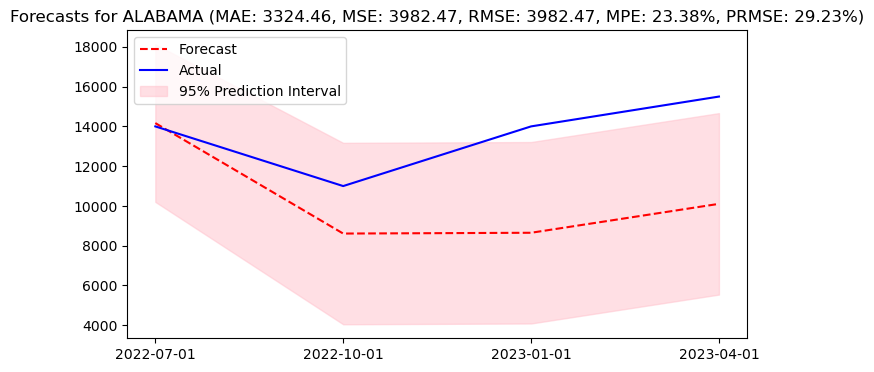

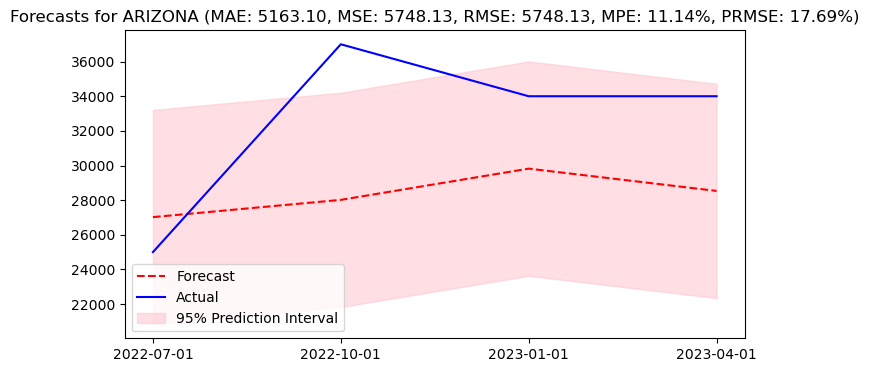

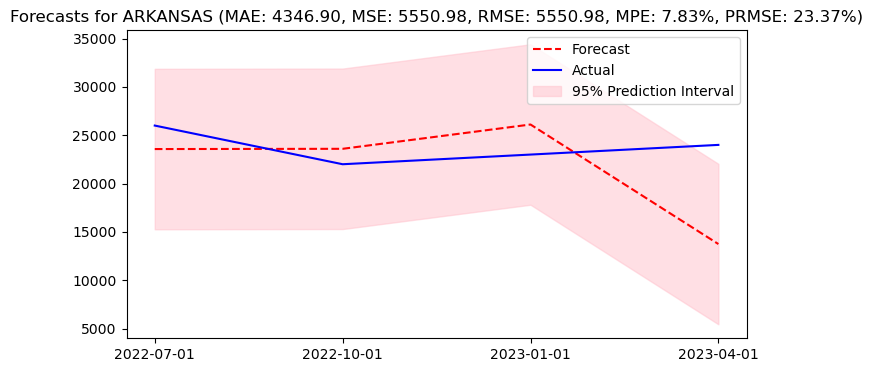

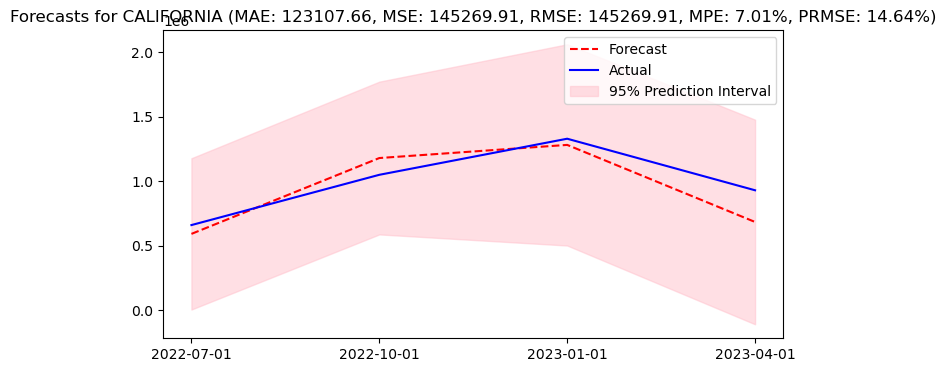

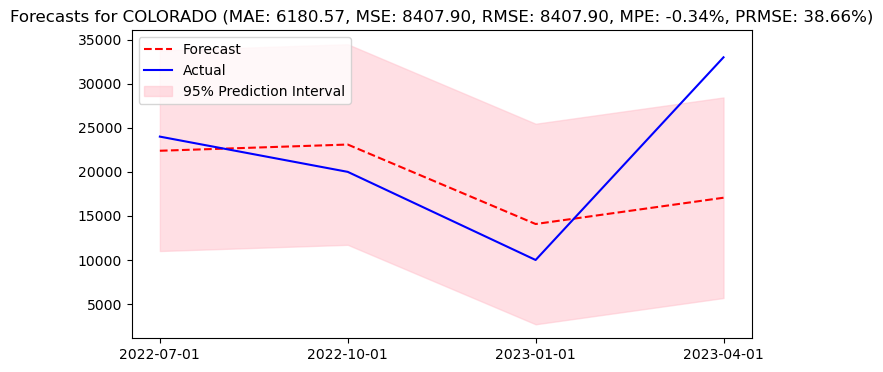

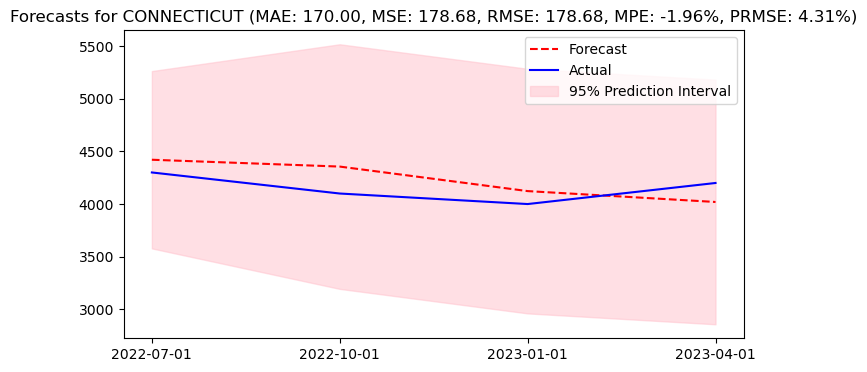

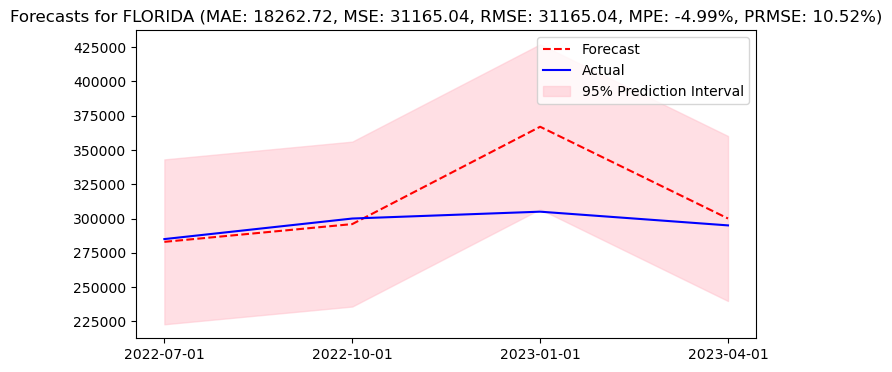

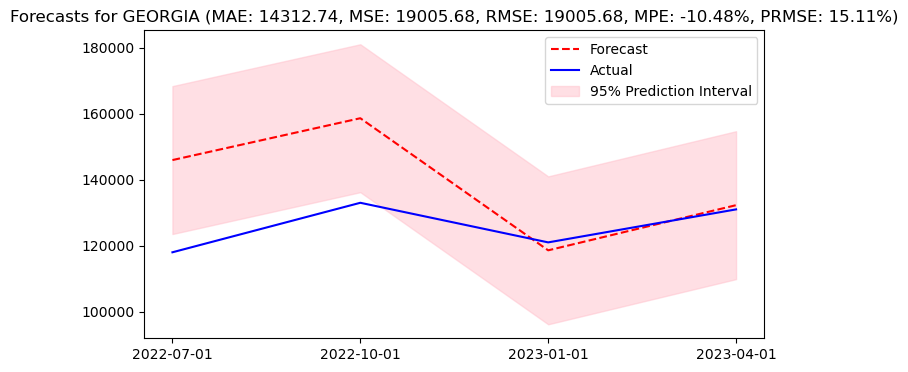

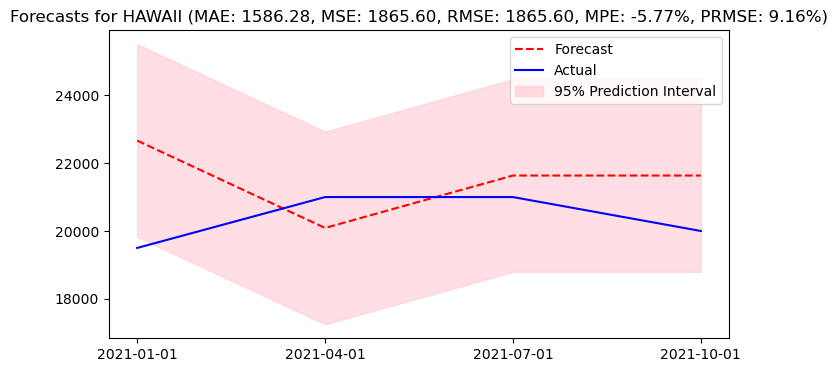

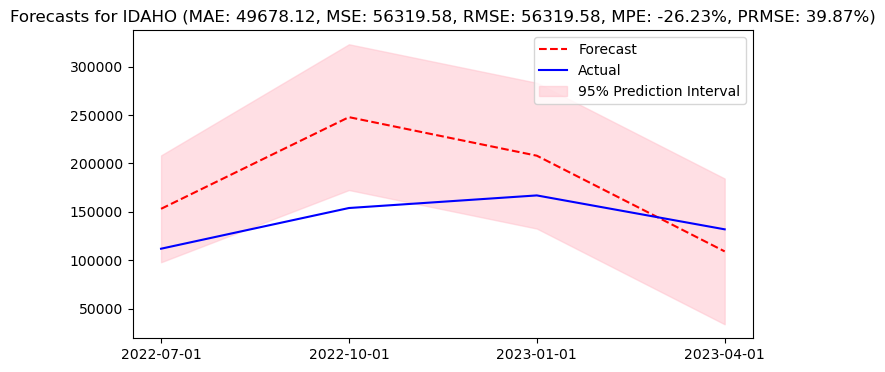

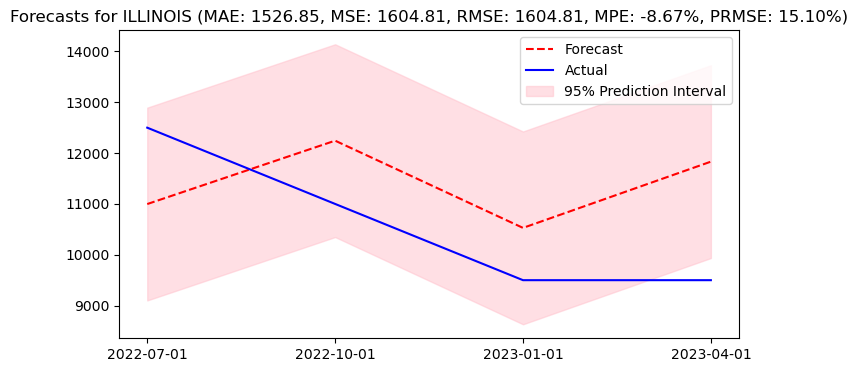

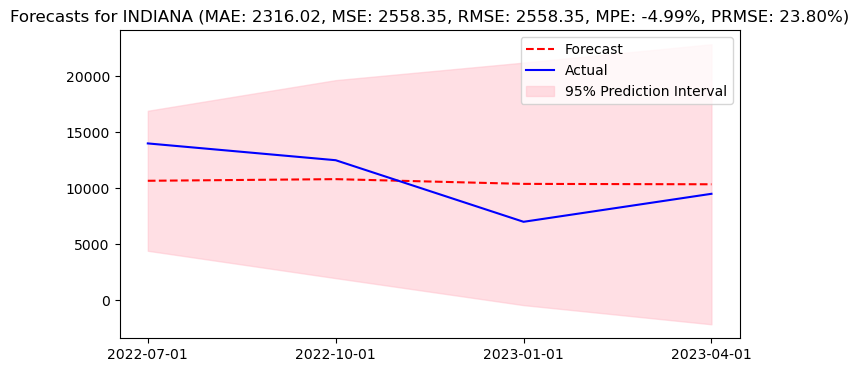

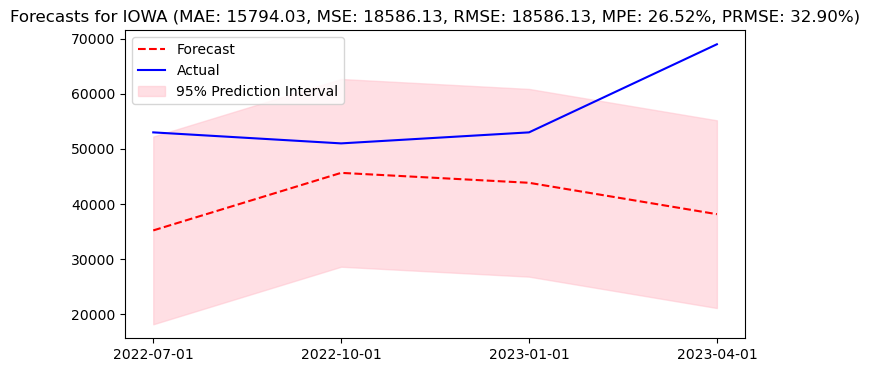

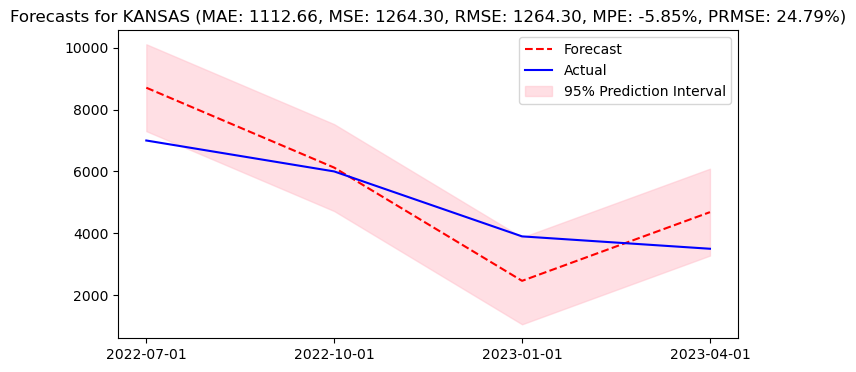

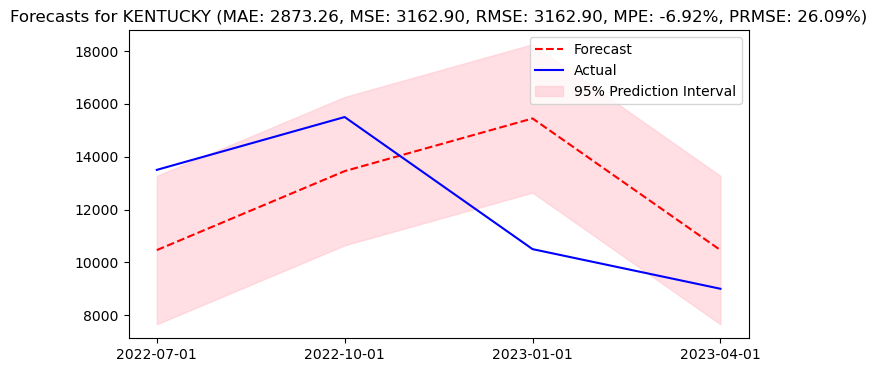

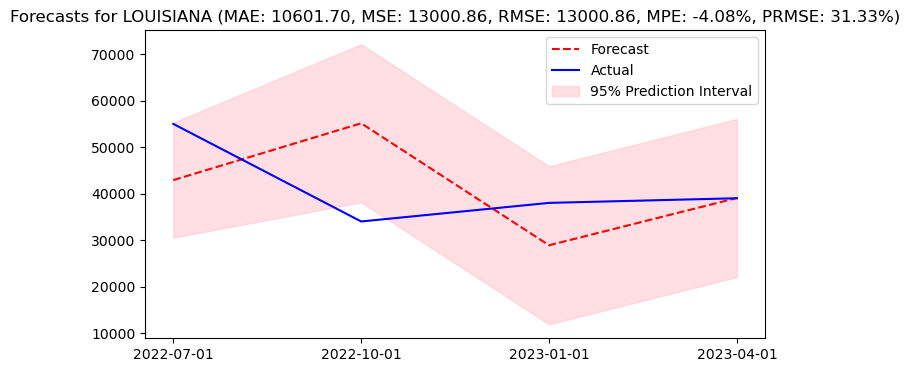

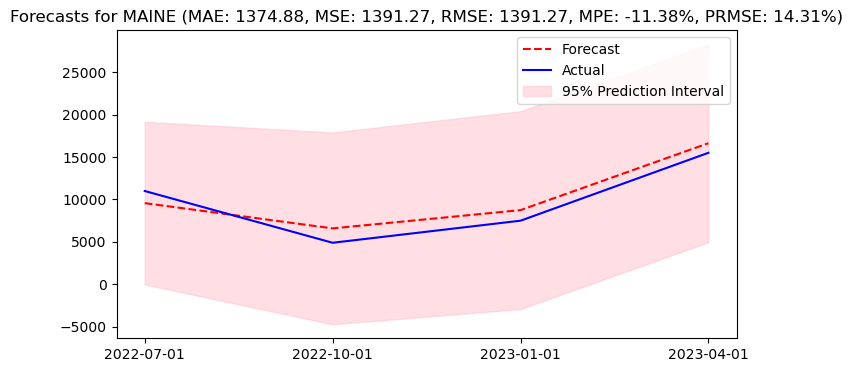

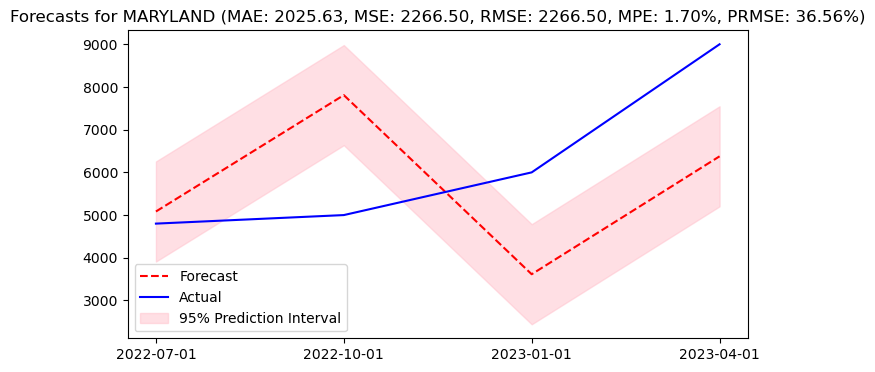

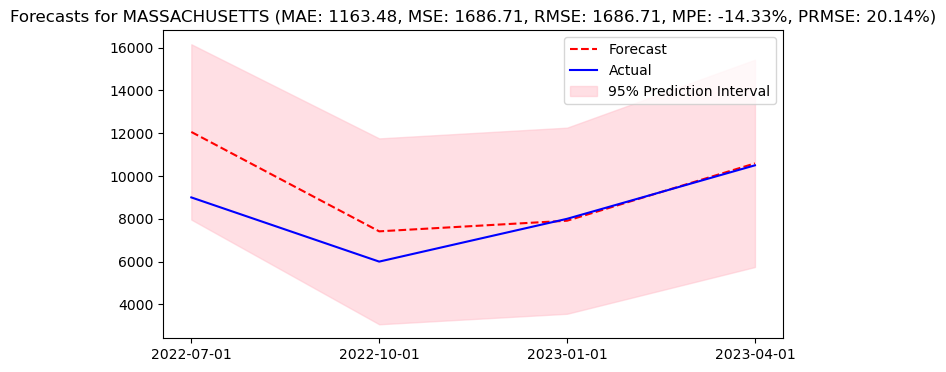

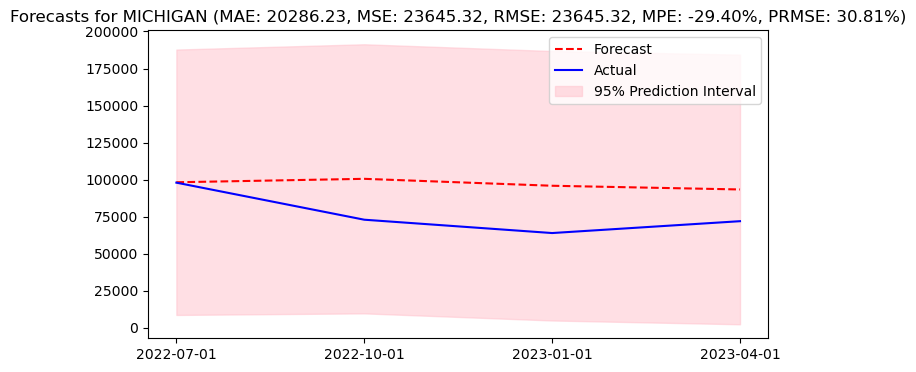

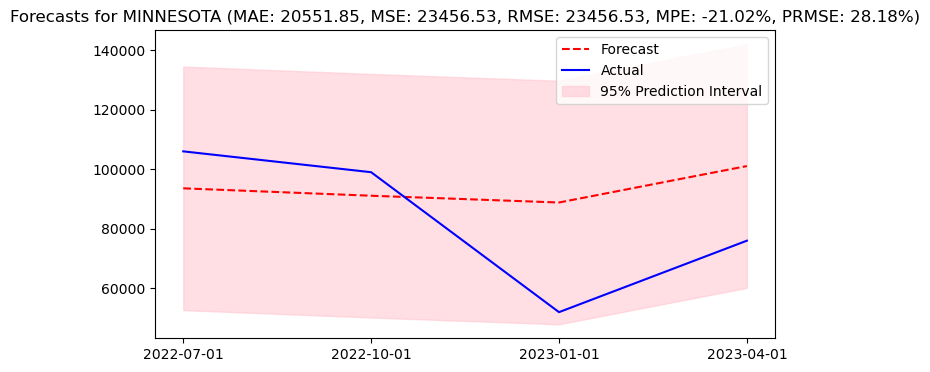

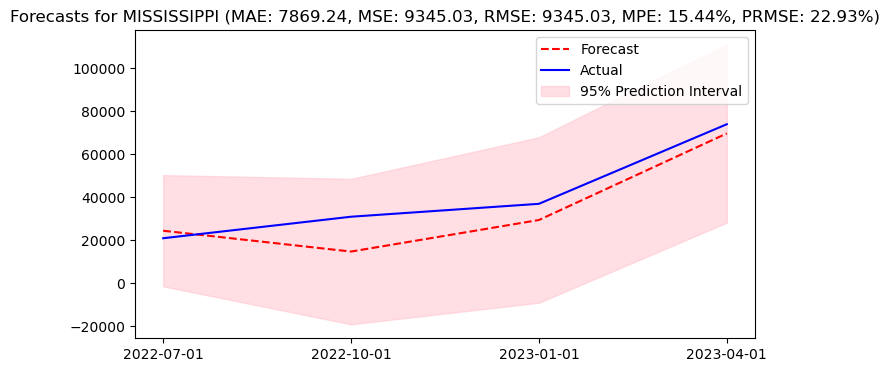

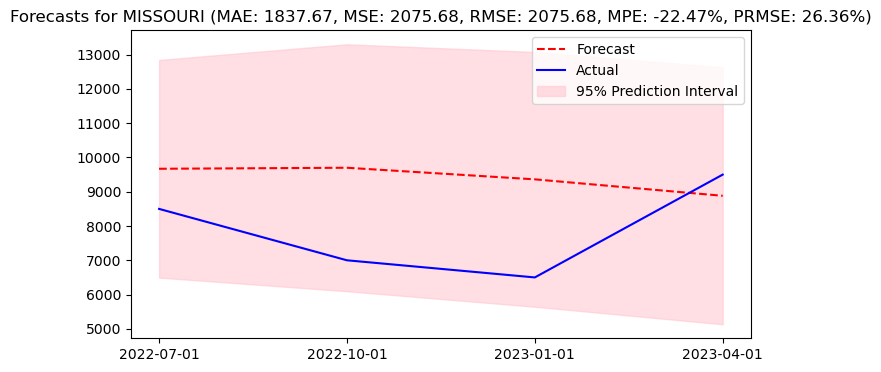

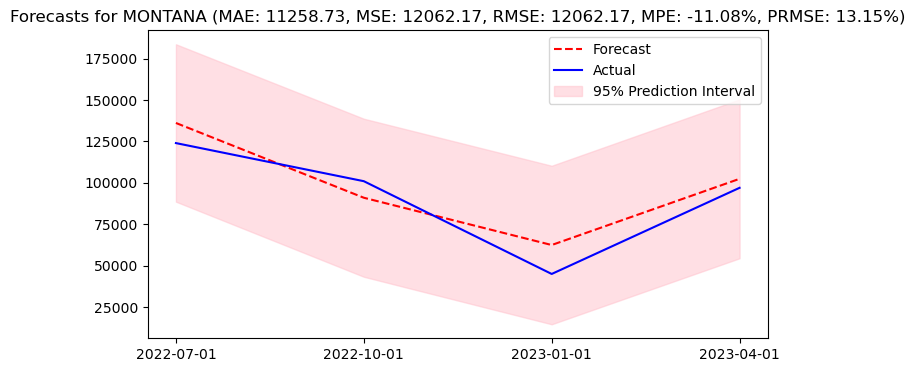

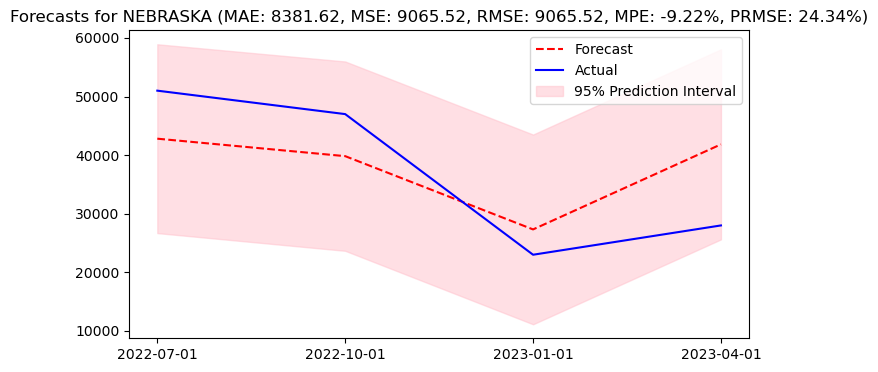

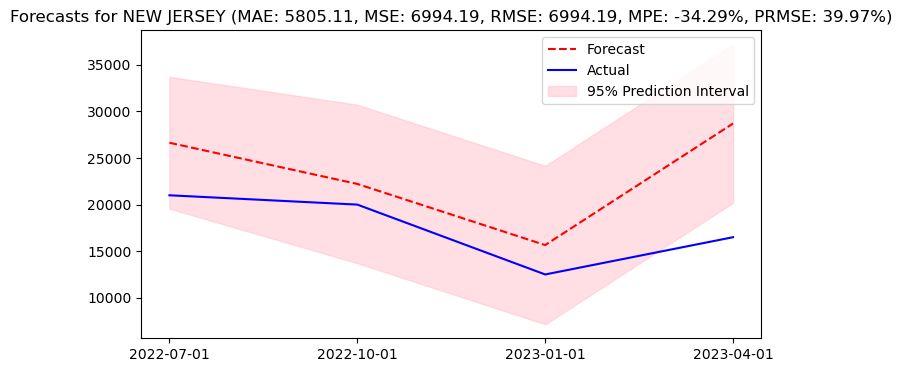

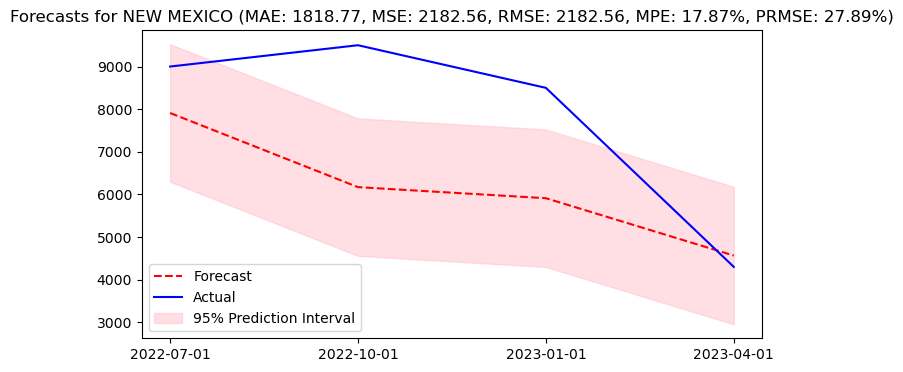

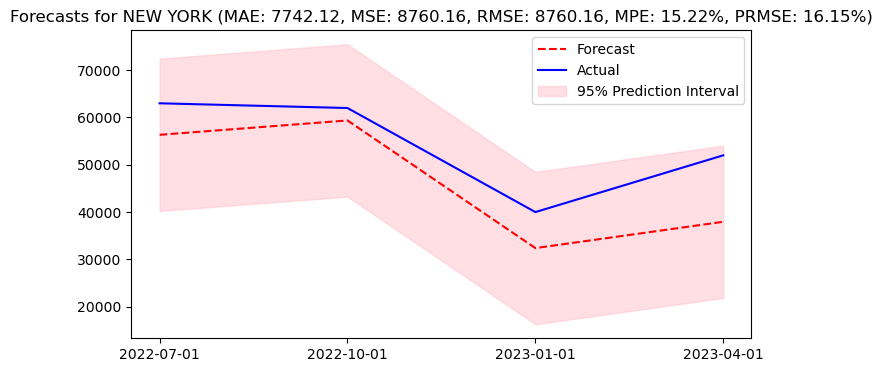

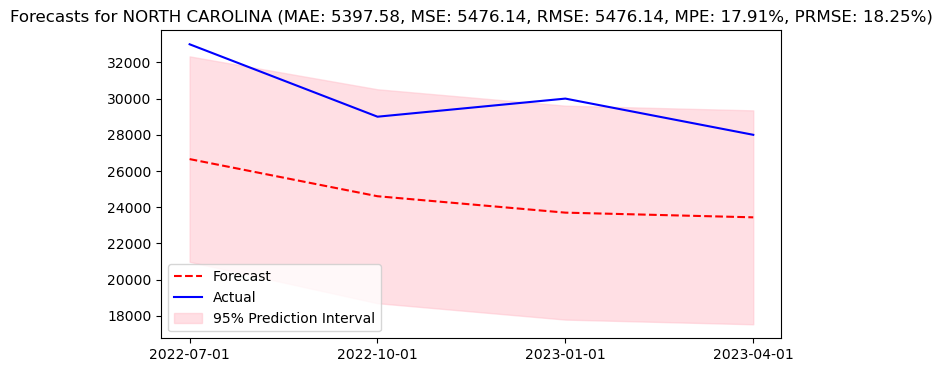

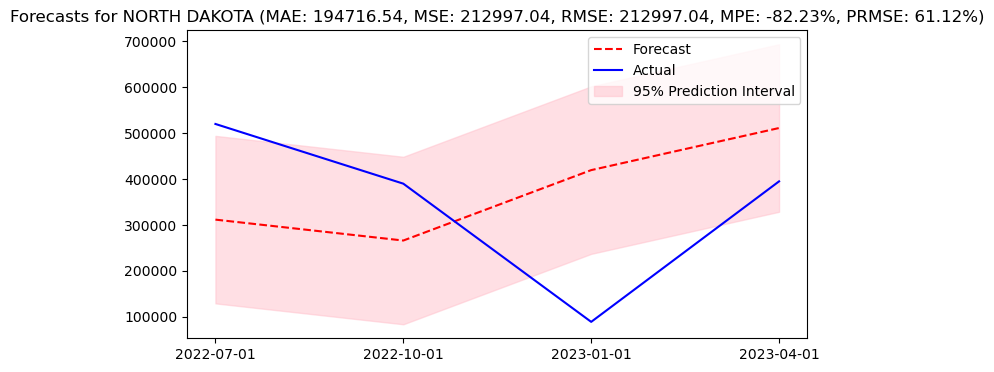

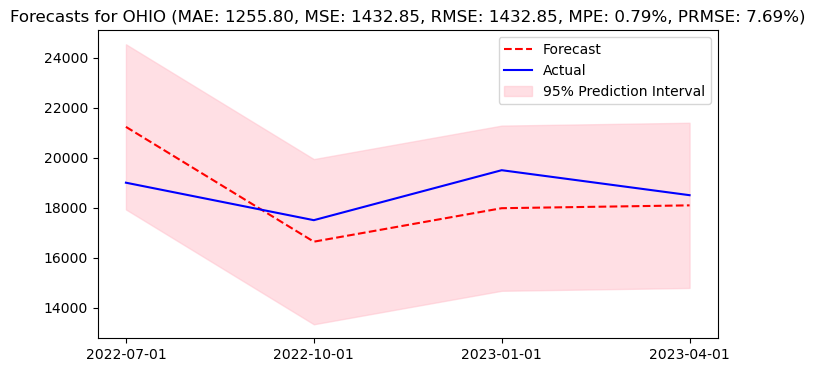

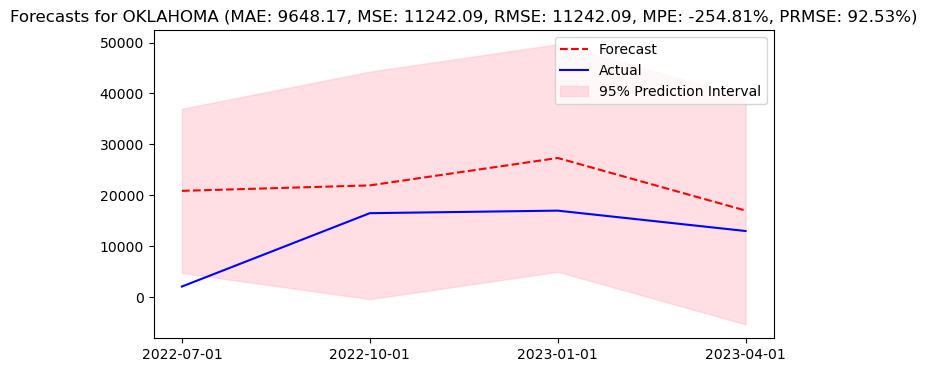

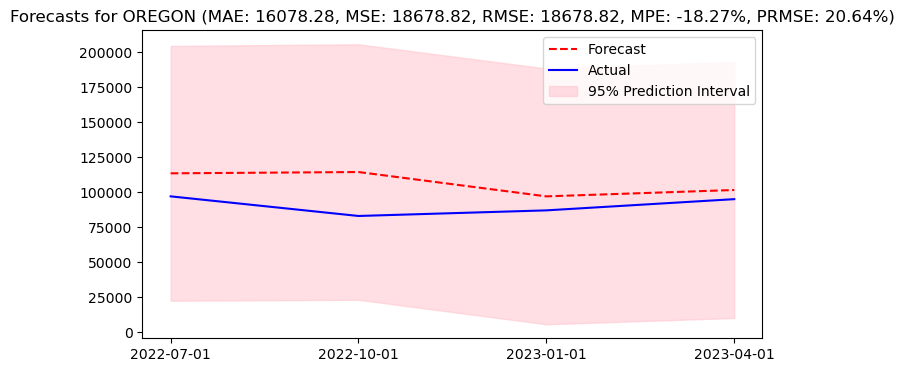

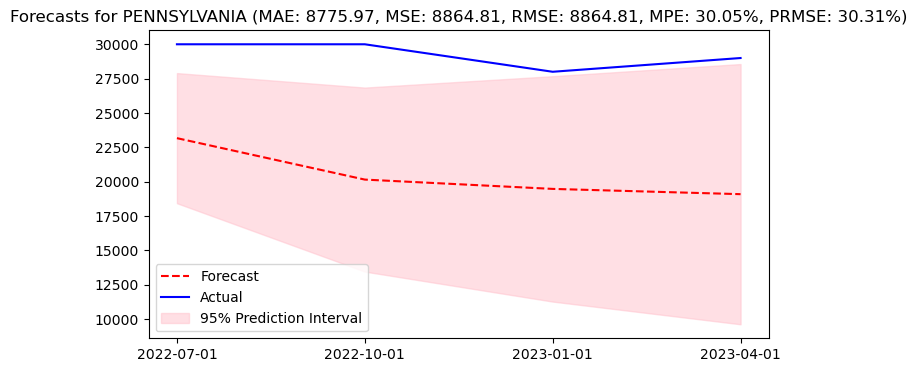

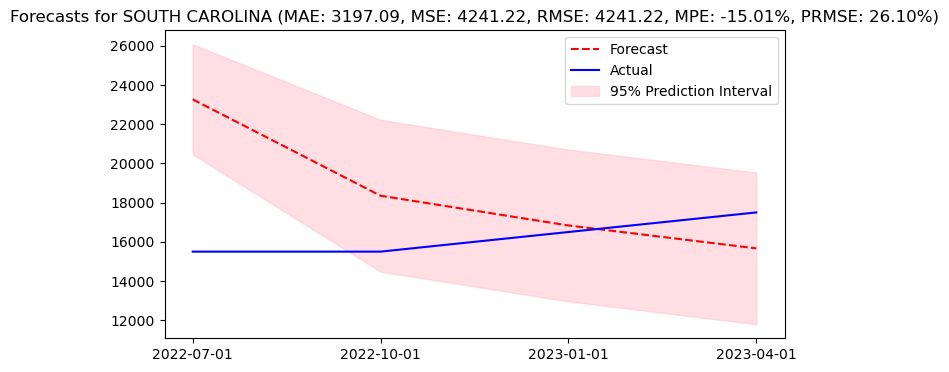

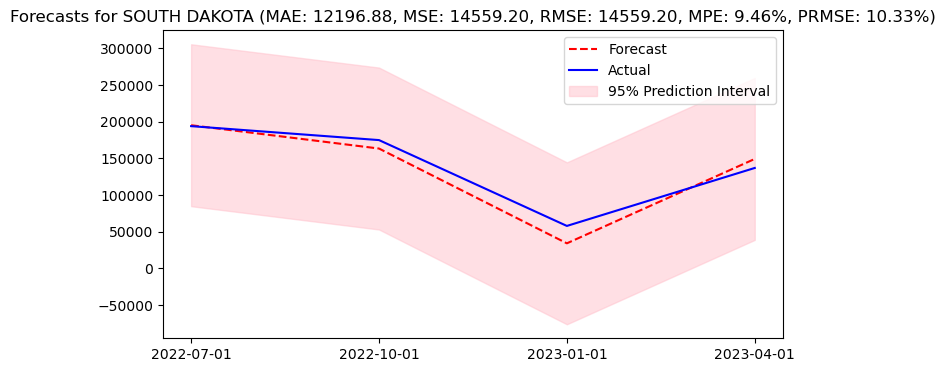

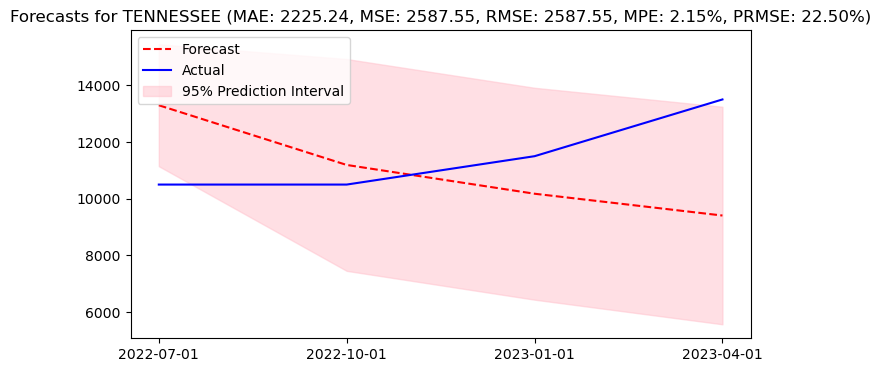

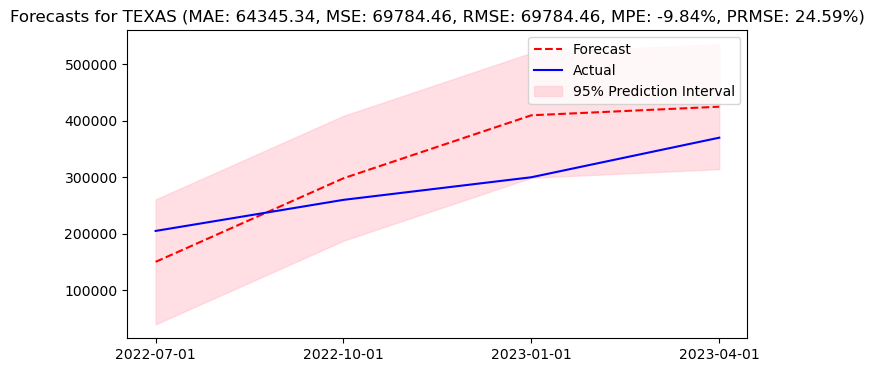

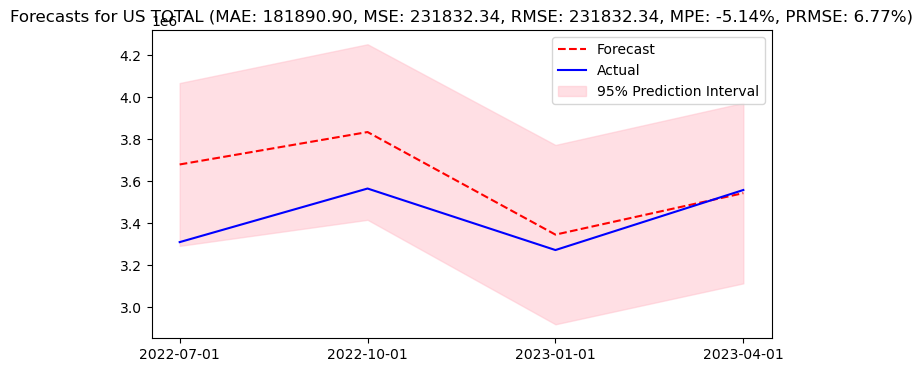

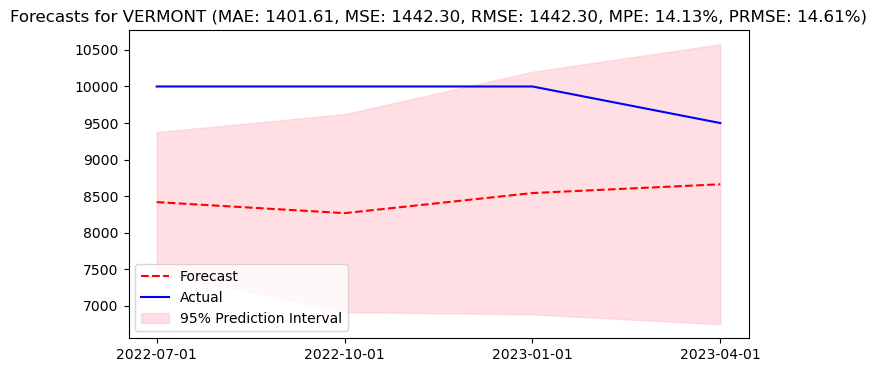

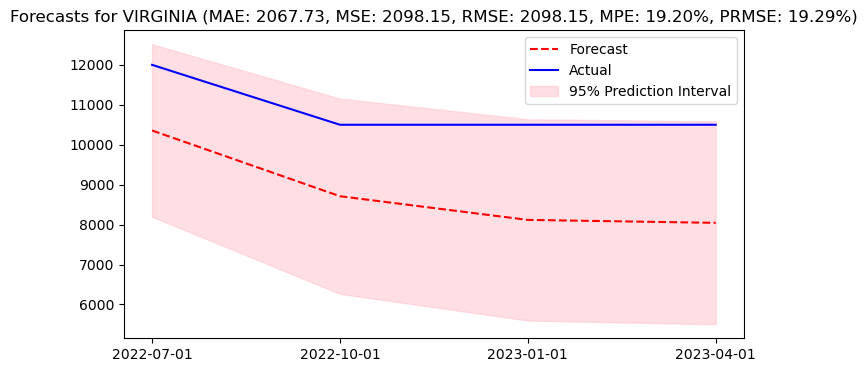

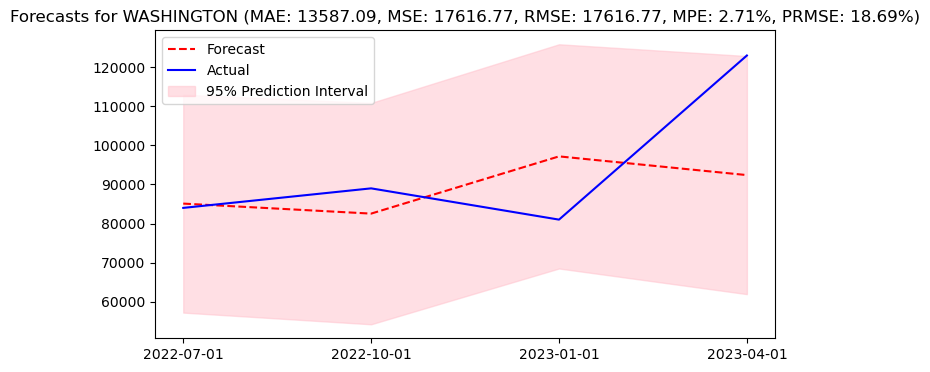

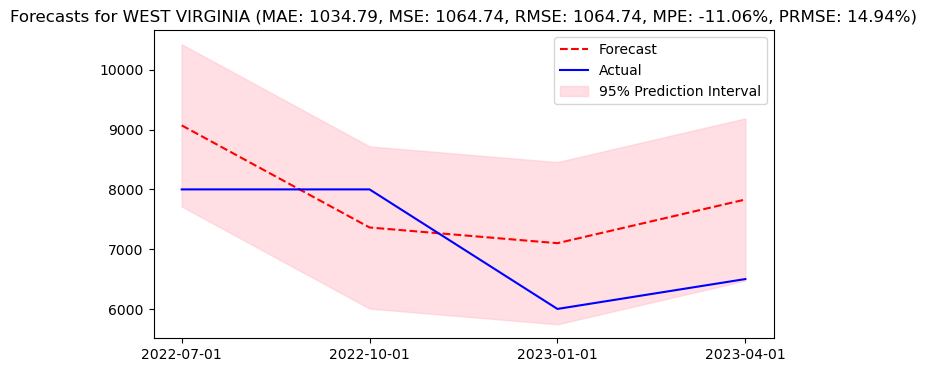

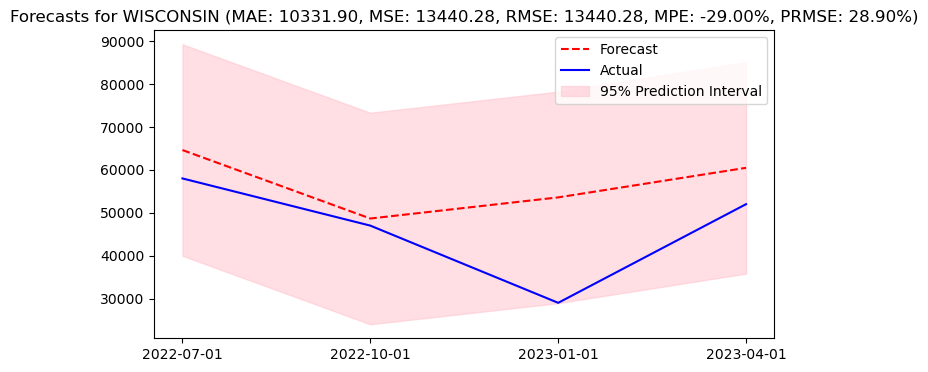

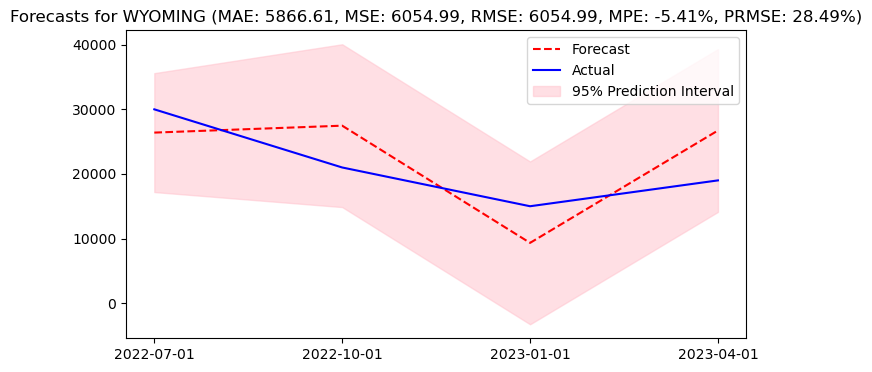

In [61]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Assuming your 'grouped' variable is a DataFrameGroupBy object

# Define the number of periods to forecast
n_periods_to_forecast = 4

# Create an empty DataFrame to store metrics and hyperparameters
metrics_df = pd.DataFrame(columns=['State', 'Order', 'Seasonal_Order', 'Selected_Features', 'MAE', 'MSE', 'RMSE', 'MPE', 'PRMSE', 'AIC'])


# Create an empty list to store skipped states and error messages
skipped_states = []

# Perform SARIMAX modeling
for state, data in grouped:
    print('Fitting SARIMAX for', state)
    data = data.drop(columns=['State'])

    try:
        # Create lagged features for all columns
        n_lags = 4

        # Create lagged features for all columns
        for col in data.columns:
            for i in range(1, n_lags + 1):
                lagged_col_name = f'{col}_lag_{i}'
                data[lagged_col_name] = data[col].shift(i)

        # Drop non-lagged features
        data = data.filter(regex='_lag|Max_Colonies')

        # Drop rows with NaN values
        data = data.dropna()

        # Split the data
        tscv = TimeSeriesSplit(n_splits=2)
        test_data = data[-n_periods_to_forecast:]
        train_data = data[:-n_periods_to_forecast]

        # Use all available features for modeling
        X_train = train_data.drop(columns=['Max_Colonies'])
        y_train = train_data['Max_Colonies']

        # Initialize variables to track the best model
        best_aic = np.inf
        best_order = None
        best_seasonal_order = None
        best_selected_features = None

        # Loop over different feature sets (1 to 5 features)
        for num_features in range(1, 6):
            # Feature selection using RFE
            rf = RandomForestRegressor()
            rfe = RFE(rf, n_features_to_select=num_features)
            rfe.fit(X_train, y_train)

            # Get selected features
            feature_ranking = rfe.ranking_
            selected_features = X_train.columns[feature_ranking == 1]
            print(selected_features)

            # Use only the selected features for modeling
            X_train_selected = X_train[selected_features]

            # Use auto_arima for automatic model selection
            autoarima_model = auto_arima(
                y_train,
                X=X_train_selected,
                m=4,
                trace=False,
                suppress_warnings=False,
                seasonal=True,
                maxiter=1000,
                start_p=1,
                start_q=1,
                max_p=5,
                max_d=5,
                max_q=5,
                start_P=1,
                start_Q=1,
                max_P=5,
                max_D=2,
                max_Q=5,
                max_order=None,
                stepwise=True
            )  # Adjust 'm' based on your frequency

            # Track AIC for the current model
            current_aic = autoarima_model.aic()

            # If current model has lower AIC, update best model information
            if current_aic < best_aic:
                best_aic = current_aic
                best_order = autoarima_model.order
                best_seasonal_order = autoarima_model.seasonal_order
                best_selected_features = selected_features

        # Forecast using the best model
        best_model = auto_arima(y_train, X=X_train[best_selected_features], order=best_order, seasonal_order=best_seasonal_order, suppress_warnings=True, maxiter=1000)
        forecasted_values, conf_int = best_model.predict(n_periods=n_periods_to_forecast, X=test_data[best_selected_features], return_conf_int=True)

        # Calculate accuracy metrics for the best model
        actual_values = test_data['Max_Colonies'].values

        mae = mean_absolute_error(actual_values, forecasted_values)
        mse = mean_squared_error(actual_values, forecasted_values)
        rmse = np.sqrt(mse)
        mpe = np.mean((actual_values - forecasted_values) / actual_values) * 100
        prmse = (rmse / np.mean(actual_values)) * 100

        # Append metrics and hyperparameters to the metrics DataFrame
        metrics_entry = {
            'State': state,
            'Order': best_order,
            'Seasonal_Order': best_seasonal_order,
            'Selected_Features': best_selected_features,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MPE': mpe,
            'PRMSE': prmse,
            'AIC': best_aic
        }
        metrics_df = metrics_df.append(metrics_entry, ignore_index=True)

        forecast_start_date = pd.period_range(start=data.index[-1].to_timestamp() + pd.DateOffset(months=3), periods=n_periods_to_forecast, freq='Q')

        test_data.index = test_data.index.to_timestamp().strftime('%Y-%m-%d')
        plt.figure(figsize=(8, 4))
        plt.plot(test_data.index, forecasted_values, label='Forecast', color='r', linestyle='dashed')
        plt.plot(test_data.index, actual_values, label='Actual', color='b')
        plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.5,
                        label='95% Prediction Interval')
        plt.title(
            f'Forecasts for {state} (MAE: {mae:.2f}, MSE: {rmse:.2f}, RMSE: {rmse:.2f}, MPE: {mpe:.2f}%, PRMSE: {prmse:.2f}%)')
        plt.legend()

        # Update progress count
        progress_count += 1
        print(f'Progress: {progress_count}/{total_states}')

    except Exception as e:
        # Handle the exception
        print(f"Error for state {state}: {e}")
        skipped_states.append({'state': state, 'error': str(e)})
        print(e)
        continue

# Print the list of skipped states and errors
print("Skipped states and errors:")
for skipped_state in skipped_states:
    print(f"State: {skipped_state['state']}, Error: {skipped_state['error']}")


In [62]:
metrics_df

State      Order Seasonal_Order  \
0          ALABAMA  (0, 0, 0)   (2, 2, 0, 4)   
1          ARIZONA  (0, 0, 1)   (0, 2, 0, 4)   
2         ARKANSAS  (0, 0, 0)   (0, 0, 0, 4)   
3       CALIFORNIA  (2, 0, 0)   (0, 0, 0, 4)   
4         COLORADO  (0, 0, 0)   (0, 0, 0, 4)   
5      CONNECTICUT  (0, 0, 2)   (0, 1, 0, 4)   
6          FLORIDA  (0, 1, 1)   (0, 0, 0, 4)   
7          GEORGIA  (0, 0, 0)   (0, 0, 0, 4)   
8           HAWAII  (2, 0, 0)   (2, 2, 0, 4)   
9            IDAHO  (0, 0, 1)   (0, 0, 0, 4)   
10        ILLINOIS  (0, 0, 0)   (2, 0, 0, 4)   
11         INDIANA  (0, 0, 1)   (0, 1, 0, 4)   
12            IOWA  (0, 0, 0)   (0, 0, 0, 4)   
13          KANSAS  (0, 0, 0)   (0, 0, 0, 4)   
14        KENTUCKY  (0, 0, 0)   (0, 1, 1, 4)   
15       LOUISIANA  (0, 0, 1)   (0, 0, 0, 4)   
16           MAINE  (2, 0, 1)   (0, 0, 0, 4)   
17        MARYLAND  (0, 0, 0)   (0, 0, 0, 4)   
18   MASSACHUSETTS  (1, 0, 0)   (0, 1, 1, 4)   
19        MICHIGAN  (1, 0, 0)   (0, 1, 0, 4)   
20       MINNESOTA  (1, 0, 1)   (0, 0, 1, 4)   
21     MISSISSIPPI  (0, 0, 3)   (1, 1, 3, 4)   
22        MISSOURI  (2, 0, 0)   (0, 1, 0, 4)   
23         MONTANA  (0, 0, 0)   (1, 0, 1, 4)   
24        NEBRASKA  (1, 0, 1)   (0, 0, 0, 4)   
25      NEW JERSEY  (1, 0, 1)   (1, 0, 1, 4)   
26      NEW MEXICO  (0, 0, 0)   (0, 1, 0, 4)   
27        NEW YORK  (0, 0, 0)   (0, 0, 0, 4)   
28  NORTH CAROLINA  (1, 0, 0)   (0, 0, 1, 4)   
29    NORTH DAKOTA  (0, 0, 0)   (1, 1, 0, 4)   
30            OHIO  (0, 0, 0)   (0, 0, 0, 4)   
31        OKLAHOMA  (0, 0, 1)   (0, 0, 0, 4)   
32          OREGON  (1, 0, 1)   (0, 1, 1, 4)   
33    PENNSYLVANIA  (0, 1, 0)   (0, 0, 0, 4)   
34  SOUTH CAROLINA  (0, 0, 1)   (0, 0, 0, 4)   
35    SOUTH DAKOTA  (0, 0, 0)   (1, 1, 0, 4)   
36       TENNESSEE  (2, 0, 2)   (0, 0, 0, 4)   
37           TEXAS  (0, 0, 0)   (0, 0, 0, 4)   
38        US TOTAL  (1, 0, 1)   (0, 0, 0, 4)   
39            UTAH  (0, 1, 0)   (0, 0, 0, 4)   
40         VERMONT  (0, 1, 0)   (0, 0, 0, 4)   
41        VIRGINIA  (1, 0, 0)   (1, 0, 0, 4)   
42      WASHINGTON  (2, 1, 0)   (0, 0, 0, 4)   
43   WEST VIRGINIA  (0, 0, 0)   (0, 0, 0, 4)   
44       WISCONSIN  (0, 0, 0)   (0, 0, 0, 4)   
45         WYOMING  (1, 0, 0)   (0, 0, 1, 4)   

                                    Selected_Features            MAE  \
0   Index(['Colonies_Added_And_Replaced_lag_1'], d...    3324.459931   
1   Index(['Pct_Affected_Other_lag_4', 'Pct_Affect...    5163.095848   
2   Index(['Pct_Affected_Pests_lag_1'], dtype='obj...    4346.900989   
3   Index(['Colonies_Added_And_Replaced_lag_3', 'M...  123107.661590   
4   Index(['Colonies_Added_And_Replaced_lag_3', 'P...    6180.565070   
5   Index(['Max_Colonies_lag_1', 'Max_Colonies_lag...     169.997758   
6   Index(['Pct_Affected_Pests_lag_2'], dtype='obj...   18262.722420   
7   Index(['Pct_Affected_Unknown_lag_1', 'Pct_Reno...   14312.742209   
8       Index(['Max_Colonies_lag_1'], dtype='object')    1586.279367   
9   Index(['Max_Colonies_lag_4', 'Pct_Affected_Oth...   49678.124581   
10  Index(['Pct_Affected_Other_lag_2', 'Pct_Affect...    1526.851575   
11  Index(['Pct_Affected_Pesticides_lag_4', 'Pct_A...    2316.020763   
12  Index(['Pct_Affected_Disease_lag_4', 'Pct_Affe...   15794.032835   
13  Index(['Colonies_Added_And_Replaced_lag_1',
  ...    1112.659326   
14      Index(['Max_Colonies_lag_1'], dtype='object')    2873.259277   
15  Index(['Colonies_Added_And_Replaced_lag_1', 'M...   10601.696132   
16      Index(['Max_Colonies_lag_4'], dtype='object')    1374.882648   
17  Index(['Pct_Affected_Deadout_lag_2', 'Pct_Affe...    2025.628864   
18  Index(['Colonies_Added_And_Replaced_lag_1', 'P...    1163.475267   
19  Index(['Pct_Affected_Pests_lag_2'], dtype='obj...   20286.229480   
20  Index(['Colonies_Added_And_Replaced_lag_3', 'M...   20551.851649   
21  Index(['Colonies_Added_And_Replaced_lag_1',
  ...    7869.243856   
22  Index(['Max_Colonies_lag_3', 'Pct_Affected_Pes...    1837.667410   
23  Index(['Max_Colonies_lag

# Future Forecasts

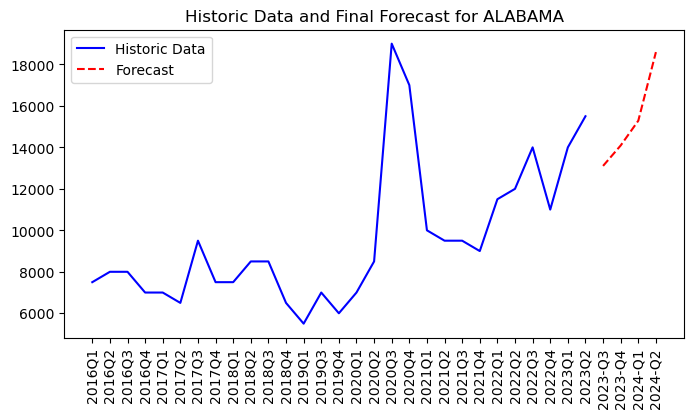

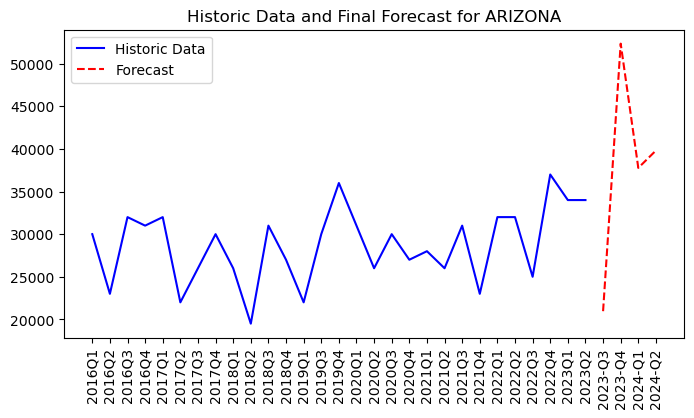

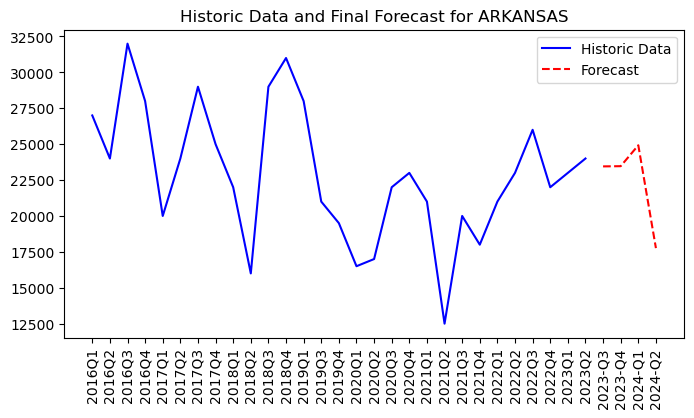

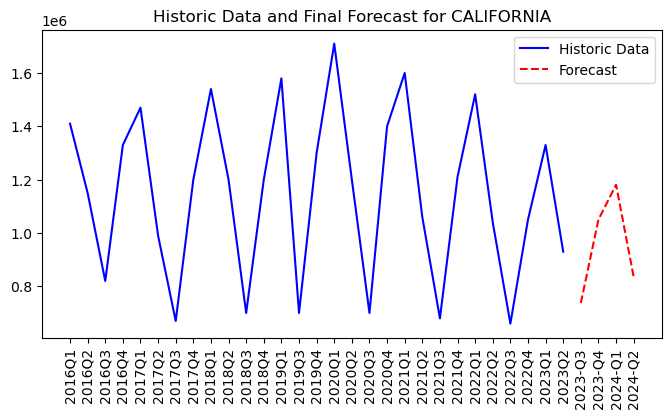

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


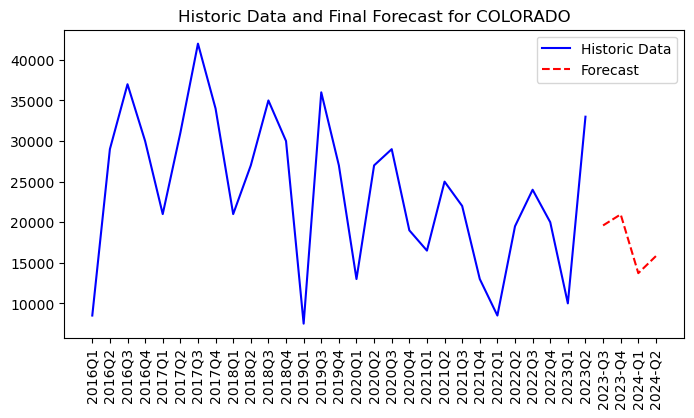

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


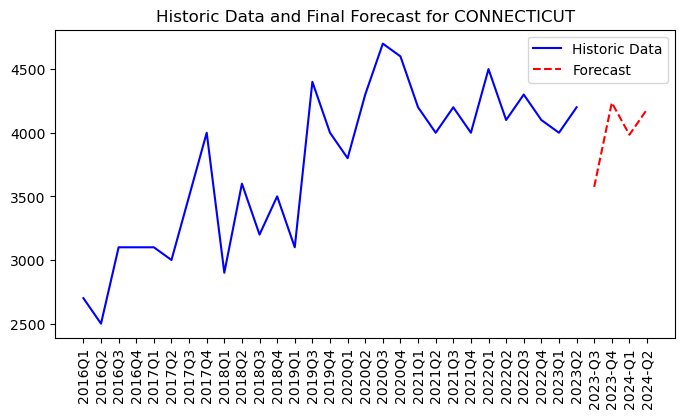

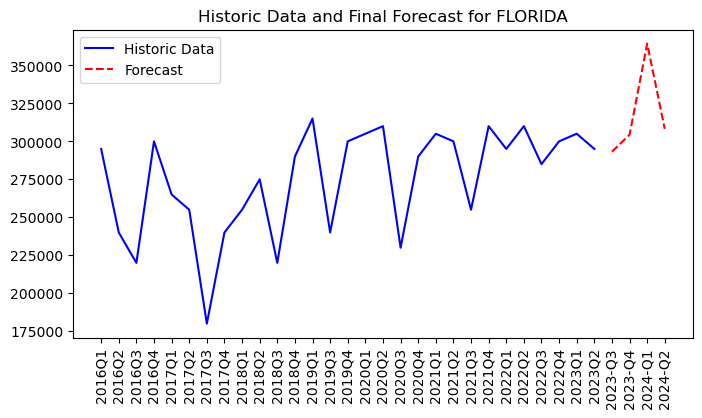

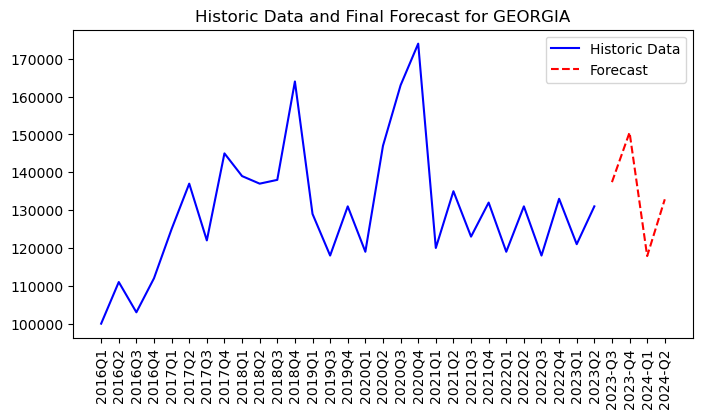

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


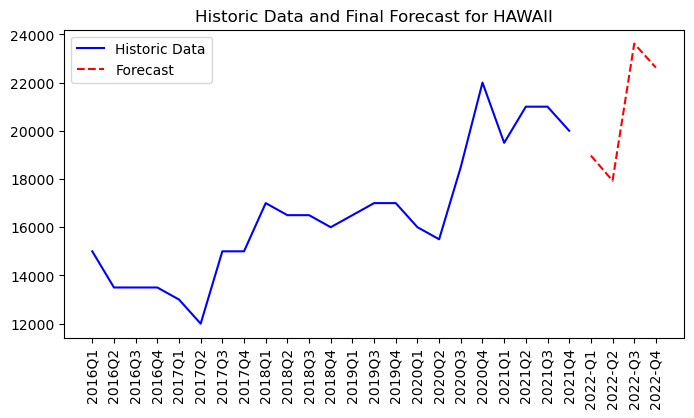

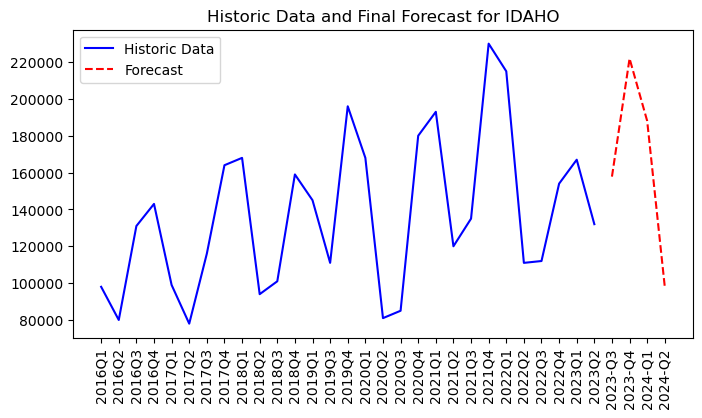

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


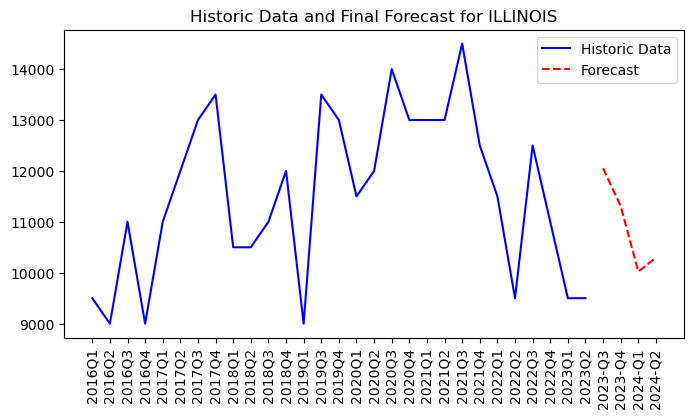

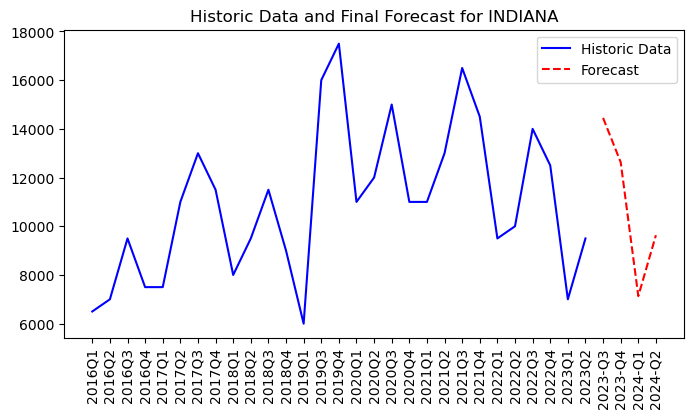

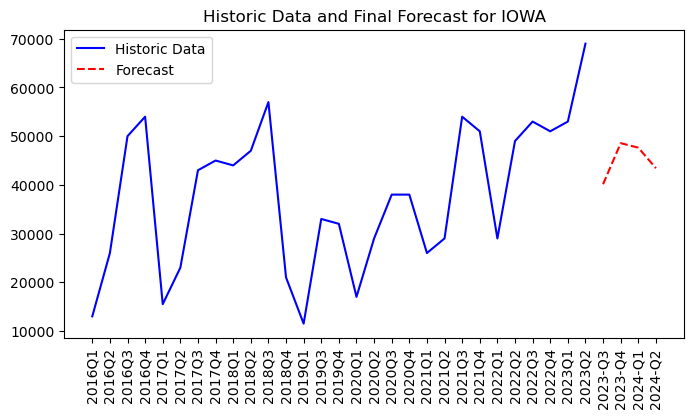

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


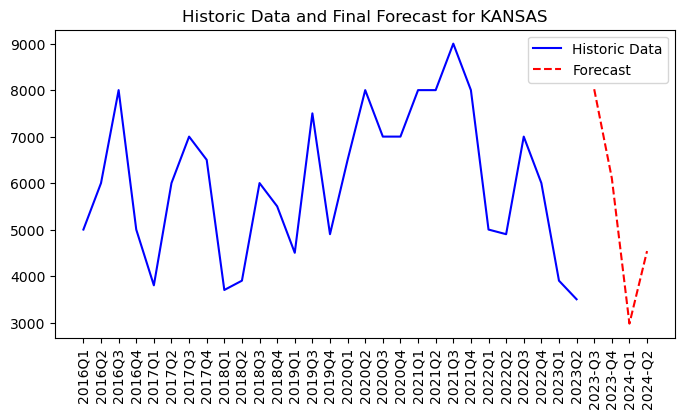

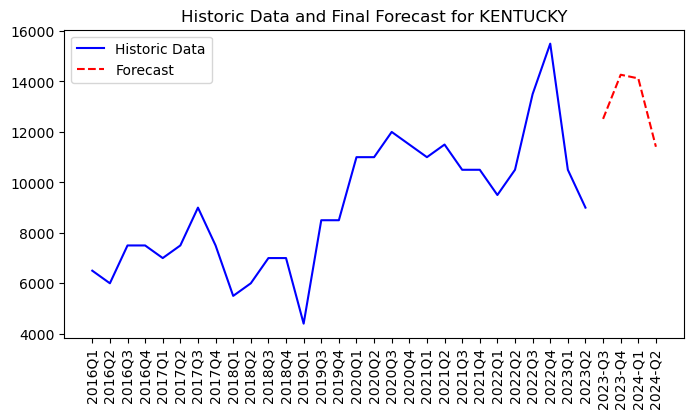

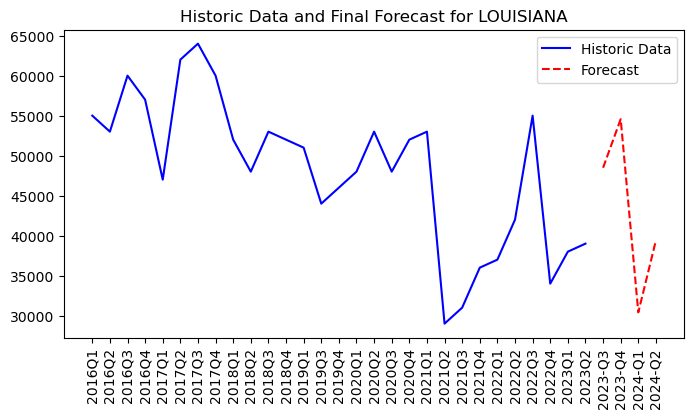

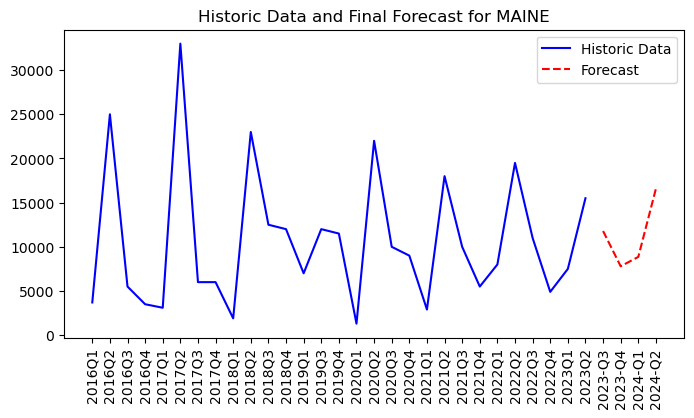

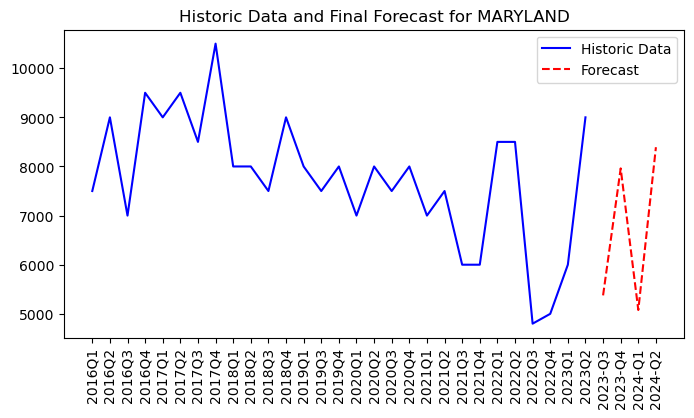

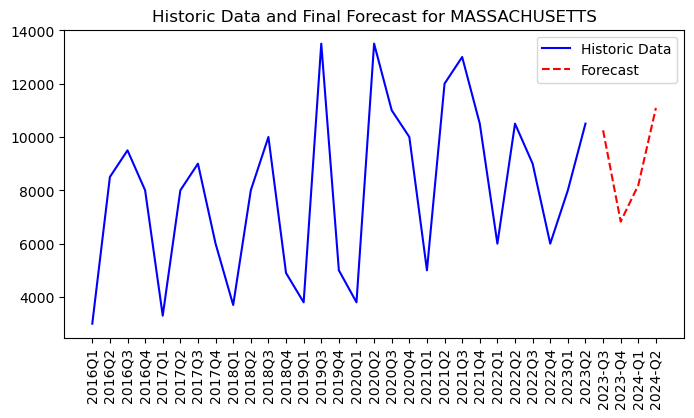

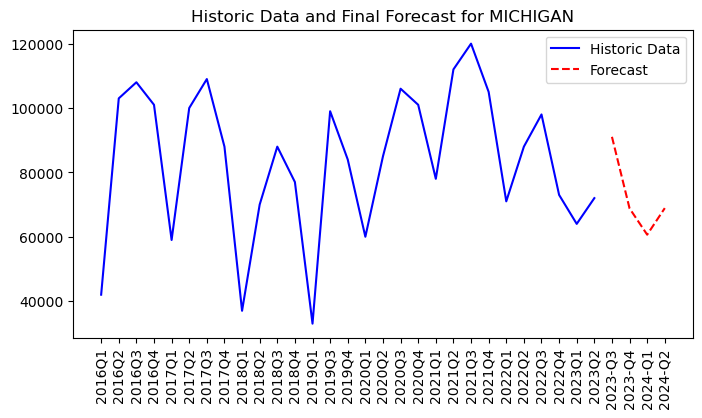

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


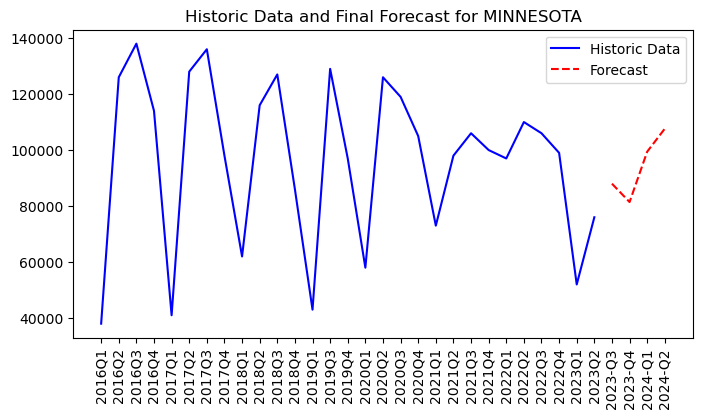

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


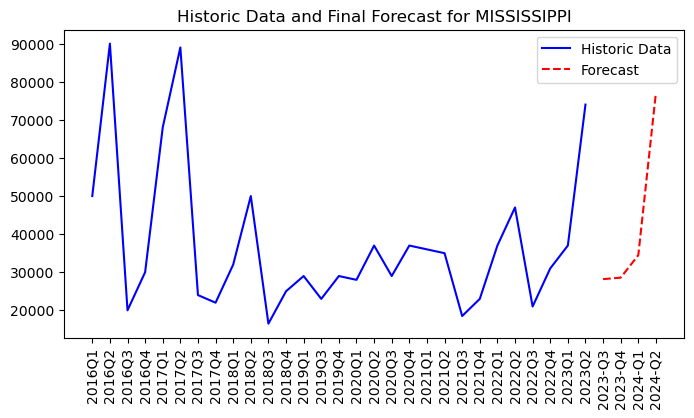

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


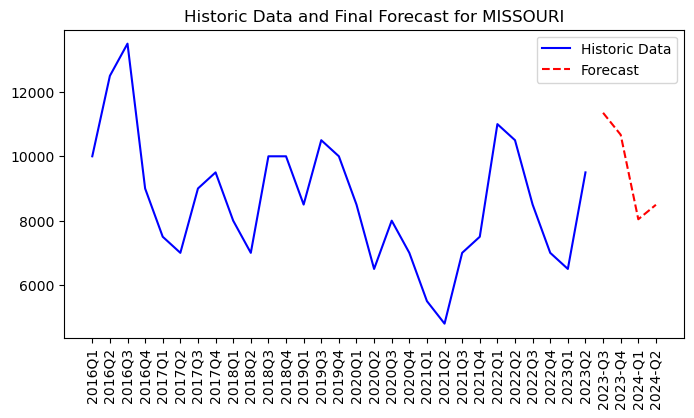

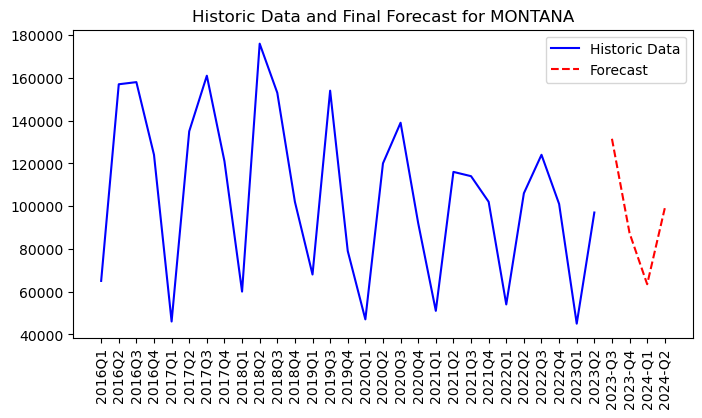

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


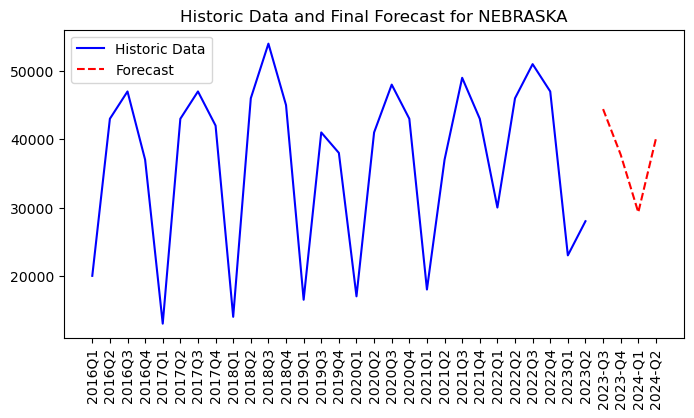

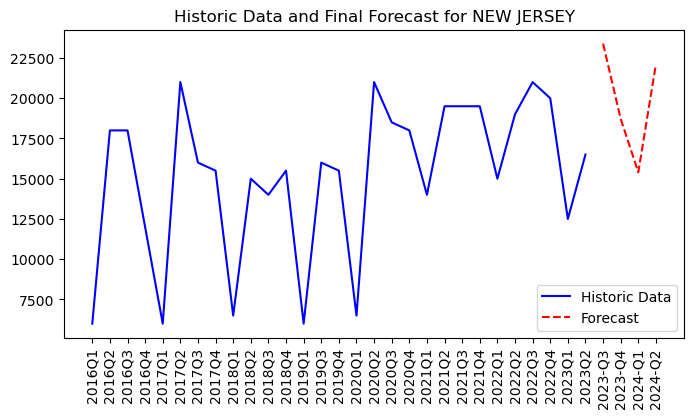

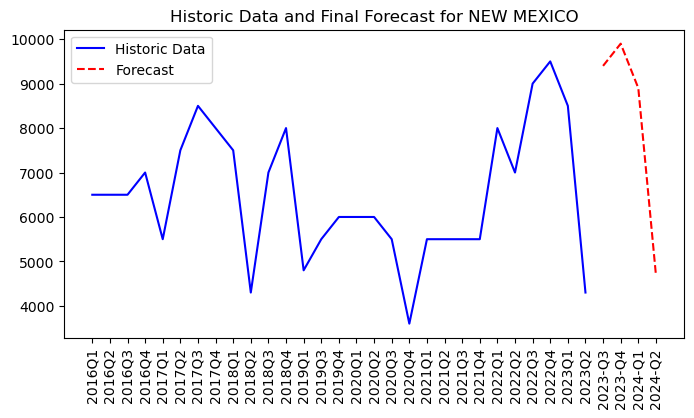

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


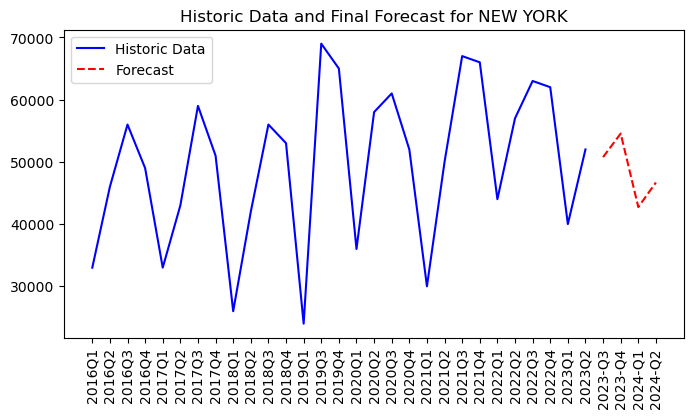

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


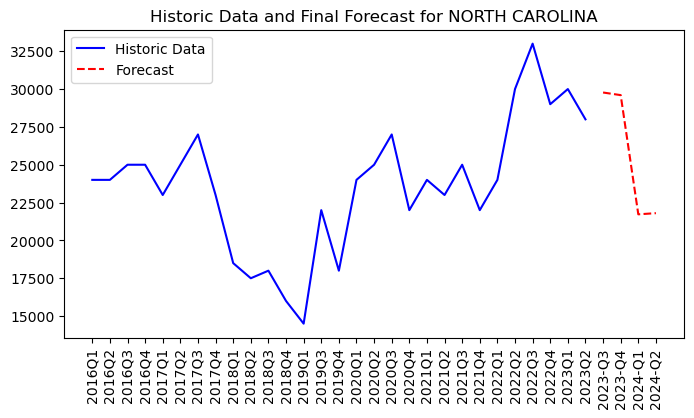

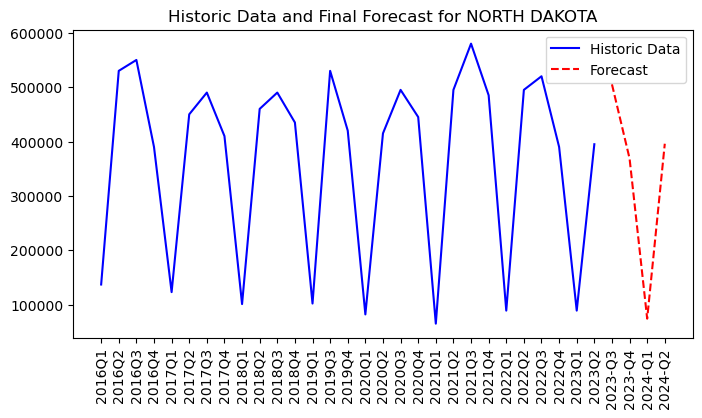

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


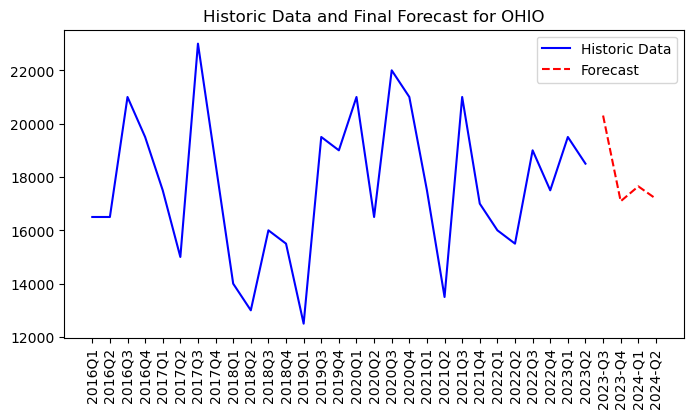

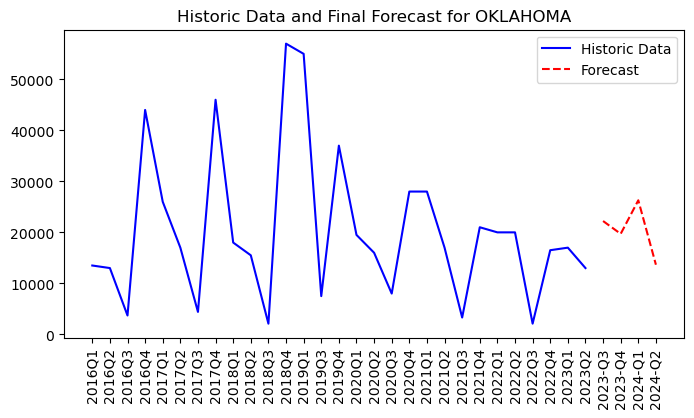

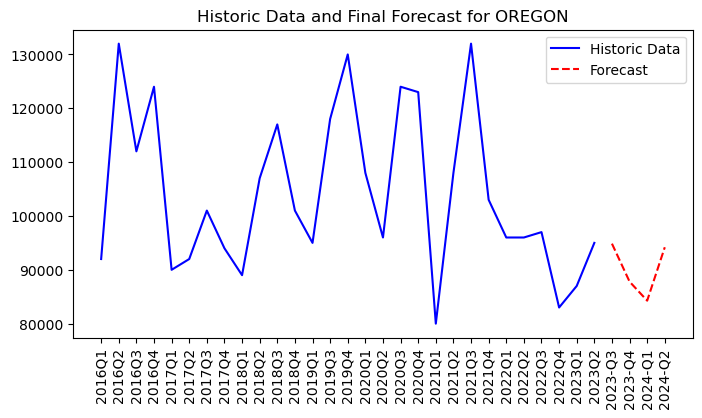

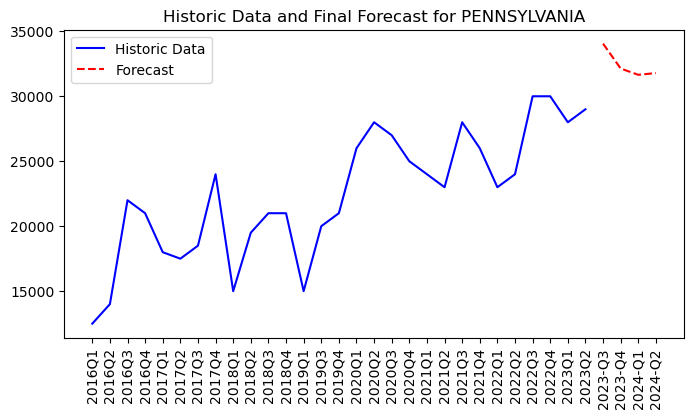

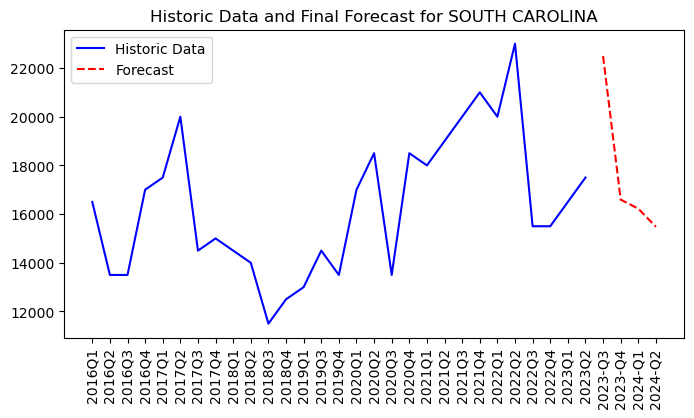

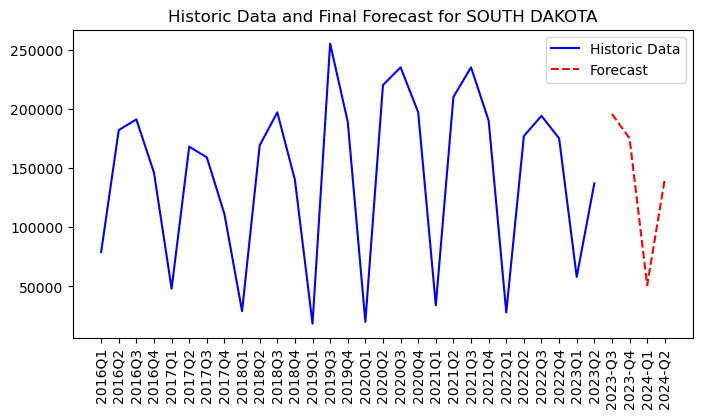

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


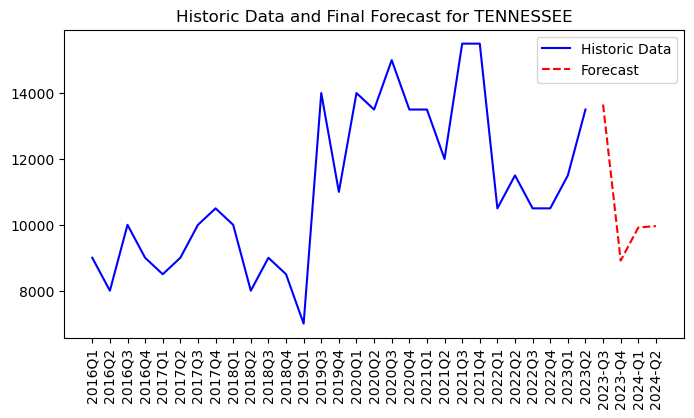

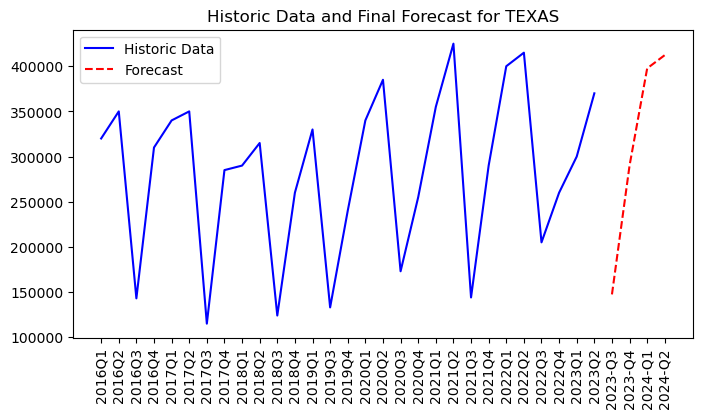

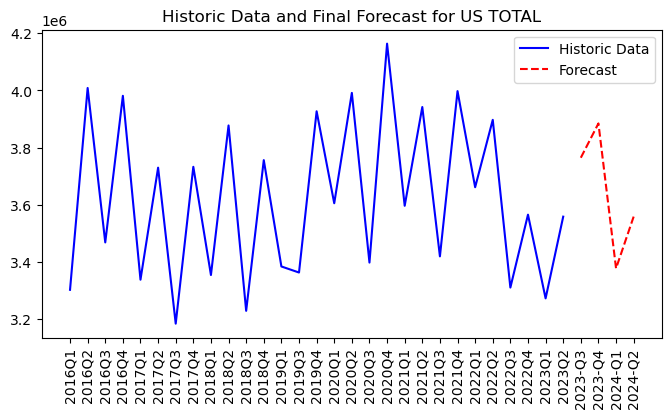

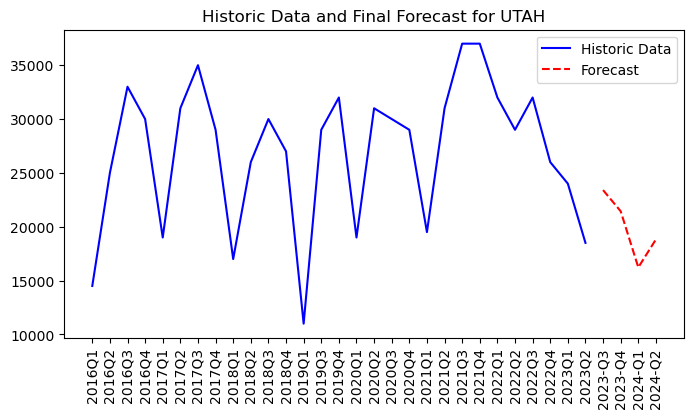

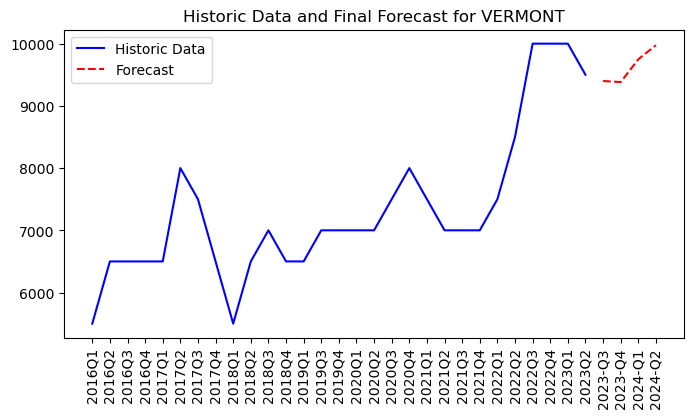

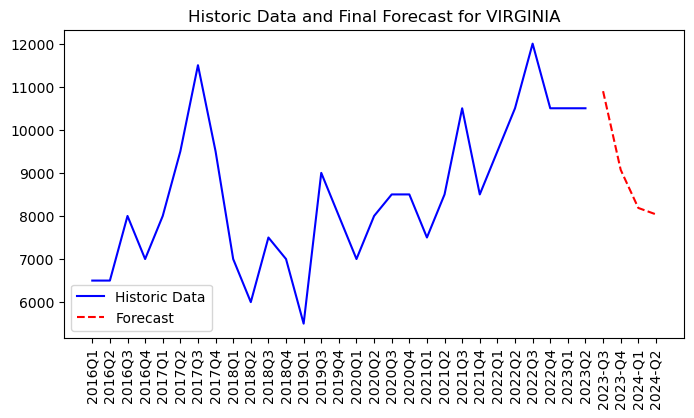

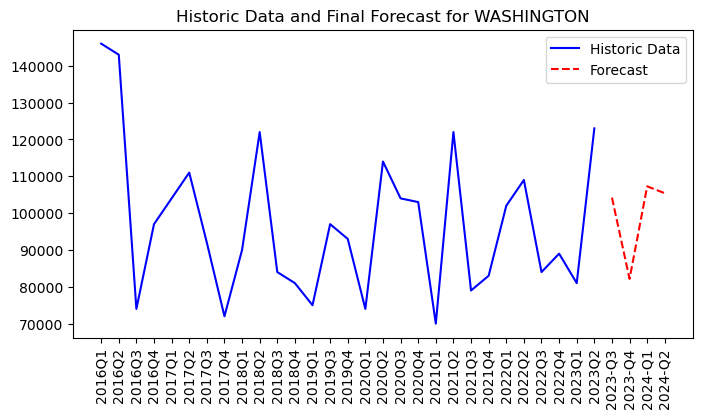

C:\Users\ckjar\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


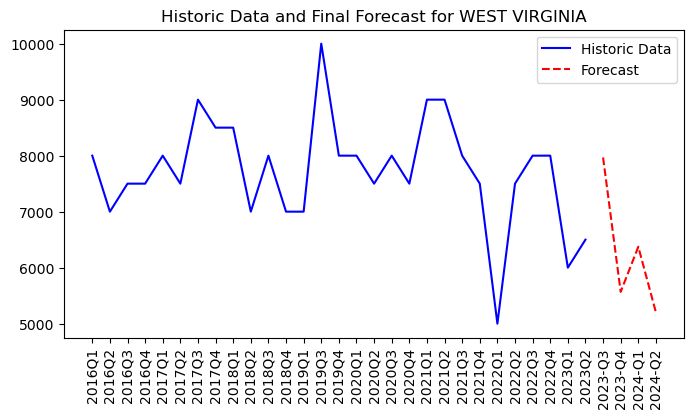

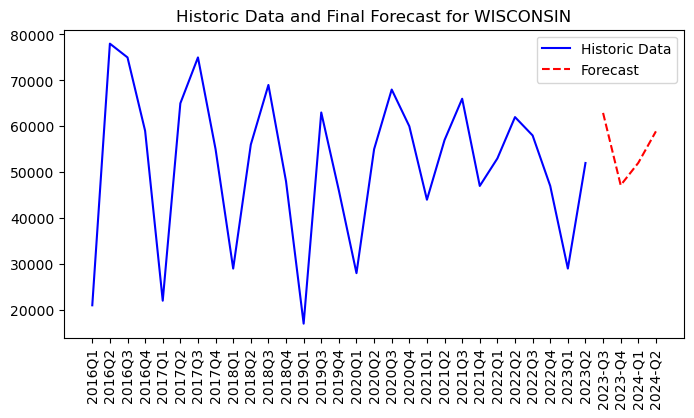

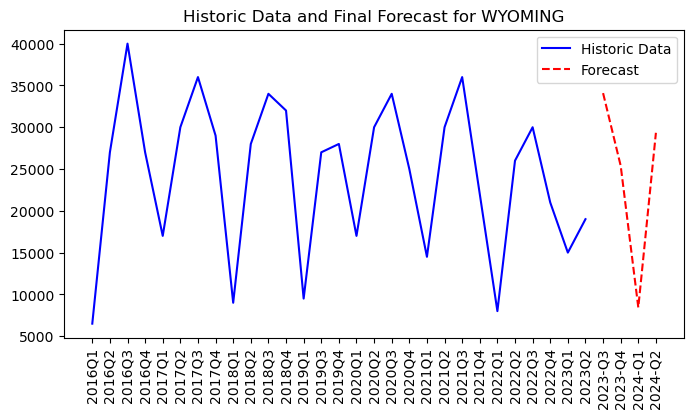

In [69]:
# Assuming your 'grouped' variable is a DataFrameGroupBy object

# Define the number of periods to forecast
n_periods_to_forecast = 4

# Create an empty DataFrame to store final forecasts
final_forecasts_df = pd.DataFrame(columns=['State', 'Forecast Quarter', 'Forecast'])

# Iterate through each state in the metrics DataFrame
for idx, row in metrics_df.iterrows():
    state = row['State']
    p, d, q = row['Order']  # Unpack order values
    P, D, Q, m = row['Seasonal_Order']  # Unpack seasonal order values
    selected_features = row['Selected_Features']
    MAE = row['MAE']
    MSE = row['MSE']
    RMSE = row['RMSE']
    MPE = row['MPE']
    PRMSE = row['PRMSE']

    # Filter historic data for the current state
    state_data = df[df['State'] == state].copy()

    # Create lagged features for all columns
    for col in state_data.columns:
        for i in range(1, n_lags + 1):
            lagged_col_name = f'{col}_lag_{i}'
            state_data[lagged_col_name] = state_data[col].shift(i)

    # Drop non-lagged features
    state_data = state_data.filter(regex='_lag|Max_Colonies')

    # Drop rows with NaN values
    state_data = state_data.dropna()


    # Use selected features for modeling
    X_train = state_data[selected_features]
    y_train = state_data['Max_Colonies']

    # Use auto_arima for forecasting with the specified parameters
    final_model = ARIMA(order=(p, d, q), seasonal_order=(P, D, Q, m), suppress_warnings=False)

    final_model.fit(y_train, X=X_train)
#     print(final_model.order)
#     print(final_model.seasonal_order)
#     print(X_train)

    # Forecast using the fitted auto_arima model
    final_forecast, conf_int = final_model.predict(n_periods=n_periods_to_forecast, X=state_data.iloc[-n_periods_to_forecast:][selected_features], return_conf_int=True)

    # Convert the forecasted values to a DataFrame and set the index
    forecast_start_date = pd.period_range(start=state_data.index[-1].to_timestamp() + pd.DateOffset(months=3), periods=n_periods_to_forecast, freq='Q')
    final_forecast_index = forecast_start_date.strftime('%Y-Q%q')

    final_forecast_values = pd.DataFrame({
        'State': [state] * n_periods_to_forecast,
        'Forecast Quarter': final_forecast_index,
        'Forecast': final_forecast,
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE,
        'MPE': MPE,
        'PRMSE': PRMSE
    })

    # Append the final_forecast_values to the final_forecasts_df
    final_forecasts_df = pd.concat([final_forecasts_df, final_forecast_values], ignore_index=True)

    # Plot the final forecast
    plt.figure(figsize=(8, 4))
    state_data_index = state_data.index.astype(str)  # Convert 'Period' to string
    plt.plot(state_data_index, state_data['Max_Colonies'], label='Historic Data', color='b')

    # Plot the final forecast in red
    plt.plot(final_forecast_index, final_forecast, label='Forecast', color='r', linestyle='dashed')

    plt.title(f'Historic Data and Final Forecast for {state}')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()


In [ ]:
forecasts = pd.pivot_table(df, values=['Forecast', 'MAE', 'MPE'], index=['Forecast Quarter', 'State'])

In [79]:
forecasts.to_csv('../Data/forecast-data.csv', index=False)